## Major League Baseball Fastball Prediction Model

by Greg Jacobs (jacobs.greg@gmail.com)

Strategy in Major League Baseball is ever-involving.  With hitters increasingly focused on launch angles and elevating the ball, it is unsurprising that teams are becoming more reliant on home runs to score. In fact, in 2019 the teams collectively hit an eye-popping 6,776 home runs, which is roughly a 10% increase over the previous record of 6,105 home runs hit in 2017.  (Data compiled and published by Baseball Almanac at https://www.baseball-almanac.com/hitting/hihr6.shtml).  This trend is very likely to continue in the coming seasons.

It also is generally-accepted that fastballs are particularly ripe for batters to hit for home runs given their increased velocity and lack of movement relative to other pitch types.  Indeed, Fantasy Labs, a website focused on providing strategic advice to fantasy sports players, noted that fastballs were the most common pitch type to be hit for home runs.  (https://www.fantasylabs.com/articles/home-run-trends-part-3-pitch-type/).   And simple common sense dictates that a batter will have an even greater chance of hitting a home if he knows that the pitcher is going to throw a fastball - one only needs to watch batting practice or the home run derby to see this confirmed.

The goal of this project is to build a model that attempts to accurately predict when a pitcher will throw a fastball. The targeted clients for this model are professional, semi-professional, and collegiate baseball teams, including the players, managers, and other personnel.  The organizations could use this data to inform their batters to anticipate fastballs under certain circumstances, which in turn should lead to the team hitting more home runs. Conversely, organizations could use this information to inform their pitchers as to when fastballs are most often thrown and coach the pitchers to throw a different pitch under those circumstances.  Professional sports gamblers could also use the model to inform their wagers.  These are just a handful of what is likely many uses for an accurate fastball prediction model.


## The Datasets

This project uses the MLB Pitch Data 2015-2018 dataset that is publicly-available on Kaggle at (https://www.kaggle.com/pschale/mlb-pitch-data-20152018).  I have chosen to build my model using two .csv files from that dataset.  The first file, `pitches.csv`, charts various data for each pitch thrown during each of the four seasons from 2015 through 2018.  The second file, `atbats.csv`, contains various static data for each at-bat from each of the four seasons from 2015 through 2018.  The two files have the following dimensions:

 `pitches.csv` == 2,870,000 x 40
 `atbats.csv` == 740,000 by 11

One of the categorical variables in the `pitches` file, `pitch_type`, classifies the pitch type for each pitch thrown.  The variable contains over fifteen distinct labels, including `FF` for a four-seam fastball, `FT` for a two-seam fastball, and `FC` for a cut-fastball.  The dataset also has a label for split-fingered fastballs, but we will treat that category as a non-fastball for the purpose of this project because the pitch operates and is used more similarly to other breaking balls (such as a sinker).  I will be able to use these labels to create a new binary variable to classify each of these three types of fastballs as a `fastballs` and the remaining categories of pitches as `non-fastballs`, which will become the target of my analysis.


## Data Cleaning/Wrangling

The data in its original form was in pretty good shape given that it came from Kaggle.  That being said, I still needed to perform some cleaning and wrangling on the respective files in order to prepare the data for analysis.

### Step 1 - Merging the Datasets

I first combined the two `.csv` files into one dataset. The two `.csv` files were merged (using `pd.merge()`) on the common `ab_id` column, which provided a unique numeric identifier for each at-bat in the `atbats` file and each pitch thrown during each at-bat in the `pitches` file.

Using the `nunique()` method in pandas, I was able to determine that the `pitches.csv` dataset has data recorded from 740,241 unique at-bats whereas the `atbats.csv` has data recorded from 740,389 unique at-bats.  Because the `pitches.csv` file is the dataset with the `pitch_type` variable that is the focus of this analysis, I decided to left-join the `atbats.csv` dataset to the `pitches.csv` so that the extra at-bats in the `atbats.csv` file would drop out.  Given the large volume of data in the `pitches.csv` data file (approximately 2.87 million unique pitches), I was comfortable only joining the corresponding at-bats from the `atbats.csv` file.

Once merged, the resulting dataframe has a dimension of (2867154, 50).


In [1]:
# import needed packages
import pandas as pd
import numpy as np
pd.options.display.max_columns = 500

In [2]:
# import the pitches dataset and isolate relevant columns
df_pitches = pd.read_csv('pitches.csv')

# count the number of unique at-bats in the dataset
df_pitches['ab_id'].nunique()

740241

In [3]:
# import the at-bats dataset and isolate relevant columns
df_atbats = pd.read_csv('atbats.csv')

# count the number of unique at-bats in the dataset
df_atbats['ab_id'].nunique()

740389

In [4]:
# merge the datasets
df = pd.merge(df_pitches, df_atbats, how='left', on='ab_id')
df.shape

(2867154, 50)

In [5]:
df.columns

Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0',
       'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'code', 'type', 'pitch_type',
       'event_num', 'b_score', 'ab_id', 'b_count', 's_count', 'outs',
       'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'batter_id', 'event', 'g_id',
       'inning', 'o', 'p_score', 'p_throws', 'pitcher_id', 'stand', 'top'],
      dtype='object')

### Step 2 - Addressing the Missing Data

A number of columns in the newly merged dataset contained some `NaN` values.  Some of the columns in the dataset are continuous numerical datatypes (floats and ints).  There were approximately 14,000 pitches that were missing almost all of their continuous numerical data.  Because all of the continuous numerical variables are tracking characteristics of the pitch after the pitcher has released it, it appears that the data collection device simply failed to track these pitches.  There are eight continuous variables that I focused on for this project:

- `start_speed` = the speed of the pitch (in miles per hour (MPH)) when the pitcher releases it;
- `end_speed` = the speed of the pitch (in MPH) when it reaches the plate;
- `break_length` = the length of the break of the pitch (in inches);
- `break_angle` = the angle of the break of the pitch (in degrees);
- `px` = the horizonal location of the pitch when it reaches the plate (0 = middle of plate);
- `pz` = the veritcal location of the pitch when it reaches the plate (0 = the ground);
- `spin_rate` = the spin rate of the pitch (in rotations per minute (RPM)); and
- `spin_dir` = the direction of the spin of the pitch (in degrees.

For this missing data in each of these columns, I elected to replace the `NaN` values with the mean value of each variable.  I did this because I wanted to maintain the ability to perform exploratory data analysis on these variables, which would not be possible if I replaced the `NaN` values with a non-numeric value (such as a `MISSING` string) because it would convert the columns to an `object` datatype.  I also did not believe that replacing the `NaN`s with the mean values would skew any calculations significantly given that the missing data makes up substantially less than 1% of the entire dataset.


In [6]:
# print out the number of NaNs for each of the continuous variable columns that we will be replacing
NaNs = []
for i in range(8):
    NaNs.append(df[df.columns[i]].isnull().sum())
print(NaNs)

[14189, 14189, 14114, 14114, 14189, 14189, 14189, 14189]


In [7]:
# replace the NaNs with the mean value for each continuous variable
for i in range(8):
    mean = np.mean(df[df.columns[i]])
    df[df.columns[i]] = df[df.columns[i]].replace(np.nan, mean)

In [8]:
# confirm that the NaNs were replaced
df['start_speed'].isnull().sum()

0

I took a different approach regarding the `NaN` values for the categorical variables.  Most of the binary categorical variables, such as `on_1b` for a runner on first base, did not contain any `NaN`s.

The first categorical variable with `NaN` values was our target `pitch_type` variable, which contains string values, including `FF` for four-seam fastballs, `FT` for two-seam fastballs, and `FC` for cut-fastballs.  I investigated into whether other columns of the dataset may inform whether the unlabeled pitches were fastballs (especially the `start_speed` and `end_speed` columns).  Unfortunately, all but five of those entries had `NaN` values for both start and end speeds, and the five that did have entries appeared to be unreliable because they contained abnormally slow outliers.  I therefore decided to replace the `NaN` values with the string `MISSING` in order to make it clear that there is no `pitch_type` label for those particular pitches.  There also were some pitches with the `UN` label for unknown.  I converted those to `MISSING` as well.

I also replaced the `NaN` values with `MISSING` string values in the `code` column because it similarly contains categorical string values.


In [9]:
# convert the pitch type missing values to 'MISSING'
df['pitch_type'] = df['pitch_type'].replace(np.nan, 'MISSING')
df['pitch_type'] = df['pitch_type'].replace('UN', 'MISSING')

# convert the code missing values to 'MISSING'
df['code'] = df['code'].replace(np.nan, 'MISSING')

### Step 3 - Create the Target 'Fastball' Label 

As noted above, I elected to group three of the `pitch_type` labels together to define a fastball for this project: `FF` for four-seam fastballs, `FT` for two-seam fastballs, and `FC` for cut-fastballs.  I will now create a binary label column for each pitch that will assign a value of 1 if the pitch is a fastball or 0 if the pitch is not.

In [10]:
# create a duplicate pitch type column
df['pitch_type2'] = df['pitch_type']

# replace all fastballs with a value of FF in duplicate column
df['pitch_type2'] = df['pitch_type2'].replace('FT', 'FF')
df['pitch_type2'] = df['pitch_type2'].replace('FC', 'FF')

# populate the fastball column with the correct values
df['fastball'] = np.where(df['pitch_type2'] == 'FF', 1, 0)

# delete the duplicate pitch type column
del df['pitch_type2']

In [11]:
df['fastball'].value_counts()

1    1502616
0    1364538
Name: fastball, dtype: int64

In [12]:
df.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,type,pitch_type,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,fastball
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,34.685,-11.960,1.72,3.56,2.0,-6.409,-136.065,-3.995,101.140000,2.280,158.780000,50.0,5.302,4.16,10.93,55.0,3.0,C,S,FF,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,1
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,34.225,-10.085,1.72,3.56,2.0,-8.411,-135.690,-5.980,124.280000,2.119,175.410000,50.0,5.307,6.57,12.00,31.0,5.0,S,S,FF,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,1
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,35.276,-11.560,1.72,3.56,2.0,-9.802,-137.668,-3.337,136.740000,2.127,150.110000,50.0,5.313,7.61,10.88,49.0,1.0,F,S,FF,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,1
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,28.354,-20.540,1.74,3.35,2.0,-8.071,-133.005,-6.567,109.685636,2.279,187.463482,50.0,5.210,1.17,6.45,41.0,13.0,B,B,FF,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,1
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,21.774,-34.111,1.72,3.56,2.0,-6.309,-110.409,0.325,146.527525,2.179,177.242829,50.0,5.557,-8.43,-1.65,18.0,13.0,B,B,CU,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,0


## Exploratory Data Analysis

### Continuous Variables

As noted above, the dataset has many features to explore. It contains a number of continuous variables documenting characteristics of each pitch once the pitcher has released it, including, among other things, each pitch's speed, location, spin/rotation, and movement.  I will run some calculations to determine whether each of these variables is statistically significant to determining whether a pitch is a fastball.

To assist with the analysis, I will first import a dataframe with the clean data so that I can run the notebook starting from this section if needed.  (Please note - the imported dataframe uses the `fastball_more` column as the target label.  This is because I used only four-seam fastballs as the targel label in the first iteration of this project, which was stored in the `fastball` column, before ultimately electing to expand the target label to include two-seam fastballs and cut-fastballs.)

I also will create new fastball and non-fastball dataframe, and write some functions to streamline the calculations.

In [1]:
%matplotlib inline

In [2]:
# import numpy, pandas, matplotlib and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 500

In [14]:
# import dataframe (if starting in this section of notebook)
#df = pd.read_csv('df_final.csv')

# create fastballs and non-fastballs dataframes
df_fastball = df[df['fastball'] == 1]
df_nofastball = df[df['fastball'] == 0]

In [15]:
# create functions for analysis

def ecdf(data):
    x=np.sort(data)
    y=np.arange(1, len(x) + 1) / len(x)
    return x, y

def graph_ecdfs(variable, x_label, graph_title):
    x, y = ecdf(df['{}'.format(variable)])
    _ = sns.set()
    _ = plt.plot(x, y, marker='.', linestyle='none', label='all pitches')
    _ = plt.xlabel('{}'.format(x_label))
    _ = plt.ylabel('ECDF')
    _ = plt.title('{}'.format(graph_title), size='large')

    x_fast, y_fast = ecdf(df_fastball['{}'.format(variable)])
    _ = plt.plot(x_fast, y_fast, marker='.', linestyle='none', label='fastballs')

    x_nofast, y_nofast = ecdf(df_nofastball['{}'.format(variable)])
    _ = plt.plot(x_nofast, y_nofast, marker='.', linestyle='none', label='non-fastballs')

    _ = plt.legend()

def calculate_stats(df, df_fastball, df_nofastball):
    df_mean = np.mean(df)
    df_median = np.nanmedian(df)
    df_std = np.std(df)
    print("all pitches mean = {}".format(df_mean))
    print('all pitches median = {}'.format(df_median))
    print('all pitches std = {}'.format(df_std))

    df_fastball_mean = np.mean(df_fastball)
    df_fastball_median = np.nanmedian(df_fastball)
    df_fastball_std = np.std(df_fastball)
    print("fastballs mean = {}".format(df_fastball_mean))
    print('fastballs median = {}'.format(df_fastball_median))
    print('fastballs std = {}'.format(df_fastball_std))

    df_nofastball_mean = np.mean(df_nofastball)
    df_nofastball_median = np.nanmedian(df_nofastball)
    df_nofastball_std = np.std(df_nofastball)
    print("non-fastballs mean = {}".format(df_nofastball_mean))
    print('non-fastballs median = {}'.format(df_nofastball_median))
    print('non-fastballs std = {}'.format(df_nofastball_std))

def perm_sample(data1, data2):
    data = np.concatenate((data1, data2))
    permutated_data = np.random.permutation(data)
    perm_sample1 = permutated_data[:len(data1)]
    perm_sample2 = permutated_data[len(data1):]
    return perm_sample1, perm_sample2

def draw_perm_reps(data1, data2, func, size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample1, perm_sample2 = perm_sample(data1, data2)
        perm_replicates[i] = func(perm_sample1, perm_sample2)
    return perm_replicates

def diff_in_means(data1, data2):
    return np.absolute(np.mean(data1) - np.mean(data2))

def bootstrap_replicate(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    bs_replicates = np.empty(size)
    for i in range (size):
        bs_replicates[i] = bootstrap_replicate(data, func)
    return bs_replicates

For each of the eight continuous variables, we will compare the data for fastballs to the data for non-fastballs. As demonstrated below both graphically and through inferential statistics, each of the variables are significant to determining whether a pitch is a fastball or not.

#### Starting Pitch Speed

<Figure size 1008x288 with 0 Axes>

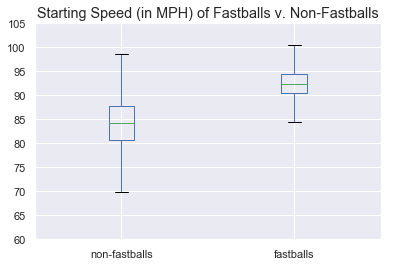

In [17]:
_ = sns.set()
_ = plt.figure(figsize=(14,4))
_ = df[['fastball', 'start_speed']].boxplot(by = 'fastball', showfliers=False).set_xticklabels(['non-fastballs', 'fastballs'])
_ = plt.title('Starting Speed (in MPH) of Fastballs v. Non-Fastballs', size='large')
_ = plt.xlabel(None)
_ = plt.ylabel(None)
_ = plt.suptitle(None)
_ = plt.ylim((60, 105))


In [18]:
# Calculating mean/median/std of each dataset

calculate_stats(df['start_speed'], df_fastball['start_speed'], df_nofastball['start_speed'])

all pitches mean = 88.38124270958095
all pitches median = 89.7
all pitches std = 6.000714632118111
fastballs mean = 92.25208030528339
fastballs median = 92.4
fastballs std = 3.113282052898194
non-fastballs mean = 84.11871392337709
non-fastballs median = 84.2
non-fastballs std = 5.506255317934194


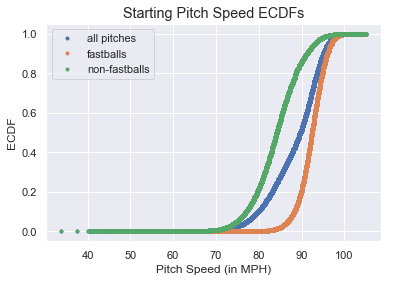

In [19]:
# Comparing the Empirical Cumulative Distribution Function (ECDF) for each of the datasets
graph_ecdfs('start_speed', 'Pitch Speed (in MPH)', 'Starting Pitch Speed ECDFs')


#### Ending Pitch Speed

<Figure size 1008x288 with 0 Axes>

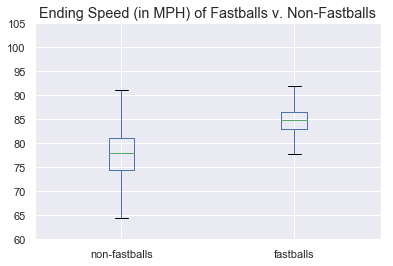

In [20]:
_ = sns.set()
_ = plt.figure(figsize=(14,4))
_ = df[['fastball', 'end_speed']].boxplot(by = 'fastball', showfliers=False).set_xticklabels(['non-fastballs', 'fastballs'])
_ = plt.title('Ending Speed (in MPH) of Fastballs v. Non-Fastballs', size='large')
_ = plt.xlabel(None)
_ = plt.ylabel(None)
_ = plt.suptitle(None)
_ = plt.ylim((60, 105))

In [21]:
# Calculating mean/median/std of each dataset
calculate_stats(df['end_speed'], df_fastball['end_speed'], df_nofastball['end_speed'])

all pitches mean = 81.36274496674785
all pitches median = 82.5
all pitches std = 5.350836604693348
fastballs mean = 84.71386069361692
fastballs median = 84.9
fastballs std = 2.797587553034777
non-fastballs mean = 77.67252885775368
non-fastballs median = 77.9
non-fastballs std = 5.055455674019069


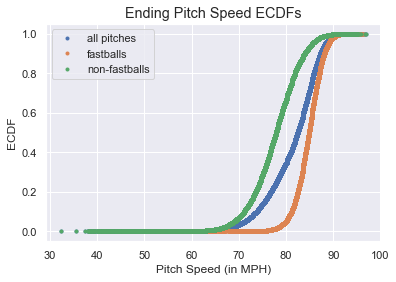

In [22]:
# Comparing the Empirical Cumulative Distribution Function (ECDF) for each of the datasets
graph_ecdfs('end_speed', 'Pitch Speed (in MPH)', 'Ending Pitch Speed ECDFs')

#### Pitch Break Length

<Figure size 1008x288 with 0 Axes>

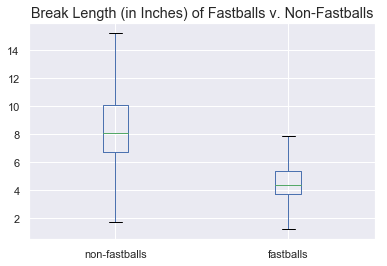

In [23]:
_ = sns.set()
_ = plt.figure(figsize=(14,4))
_ = df[['fastball', 'break_length']].boxplot(by = 'fastball', showfliers=False).set_xticklabels(['non-fastballs', 'fastballs'])
_ = plt.title('Break Length (in Inches) of Fastballs v. Non-Fastballs', size='large')
_ = plt.xlabel(None)
_ = plt.ylabel(None)
_ = plt.suptitle(None)

In [24]:
# Calculating mean/median/std of each dataset
calculate_stats(df['break_length'], df_fastball['break_length'], df_nofastball['break_length'])

all pitches mean = 6.601459078537077
all pitches median = 6.0
all pitches std = 132.84080792371856
fastballs mean = 4.756373750845235
fastballs median = 4.4
fastballs std = 183.4624226207751
non-fastballs mean = 8.633249131108181
non-fastballs median = 8.1
non-fastballs std = 2.605043719352486


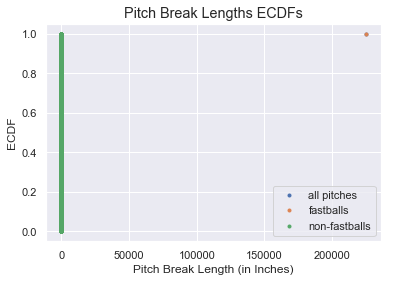

In [25]:
# Comparing the Empirical Cumulative Distribution Function (ECDF) for each of the datasets
graph_ecdfs('break_length', 'Pitch Break Length (in Inches)', 'Pitch Break Lengths ECDFs')

It looks like the `break_length` column has an outlier that needs to be addressed:

In [33]:
# Identifying the outlier
outlier = df_fastball[df_fastball['break_length'] > 150000]
outlier.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,type,pitch_type,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,fastball
2063015,1.358352,7.539096,95.7,96.4,524.129,136.431,2.5,224889.3,36.4,3.488136,-0.524375,-28.507316,1.378487,3.165522,2.0,5.947644,-140.082309,1.603897,93.19,-0.912584,189.18,50.0,8.695458,1.585252,1.666419,19.0,12.0,X,X,FC,220,0.0,2.017165e+09,1.0,2.0,2.0,4.0,0.0,0.0,0.0,405395,Groundout,201702160,4,3,1,R,434378,R,False,1


In [34]:
# Replacing the outlier with the mean break length value in both df and df_fastball dataframes
df_fastball.loc[2063015, 'break_length'] = 6.60
df.loc[2063015, 'break_length'] = 6.60

C:\Users\Owner\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


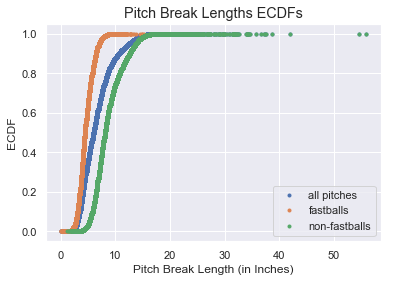

In [35]:
# Re-running the ECDF graph
graph_ecdfs('break_length', 'Pitch Break Length (in Inches)', 'Pitch Break Lengths ECDFs')

#### Pitch Break Angles

<Figure size 1008x288 with 0 Axes>

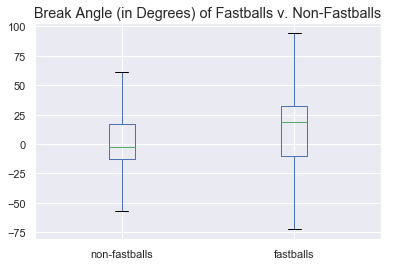

In [36]:
_ = sns.set()
_ = plt.figure(figsize=(14,4))
_ = df[['fastball', 'break_angle']].boxplot(by = 'fastball', showfliers=False).set_xticklabels(['non-fastballs', 'fastballs'])
_ = plt.title('Break Angle (in Degrees) of Fastballs v. Non-Fastballs', size = 'large')
_ = plt.xlabel(None)
_ = plt.ylabel(None)
_ = plt.suptitle(None)

In [37]:
# Calculating mean/median/std of each dataset
calculate_stats(df['break_angle'], df_fastball['break_angle'], df_nofastball['break_angle'])

all pitches mean = 5.848084186098598
all pitches median = 6.5
all pitches std = 24.375667737867555
fastballs mean = 10.452149517907374
fastballs median = 18.7
fastballs std = 27.007262383116437
non-fastballs mean = 0.7781321344780832
non-fastballs median = -2.7
non-fastballs std = 19.905388088869337


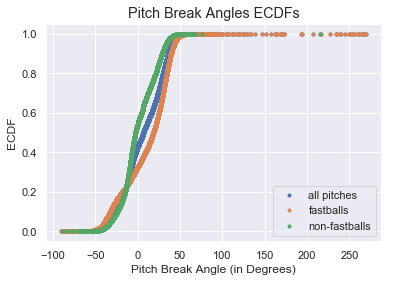

In [38]:
# Comparing the Empirical Cumulative Distribution Function (ECDF) for each of the datasets
graph_ecdfs('break_angle', 'Pitch Break Angle (in Degrees)', 'Pitch Break Angles ECDFs')

#### Horizontal Pitch Location

<Figure size 1008x288 with 0 Axes>

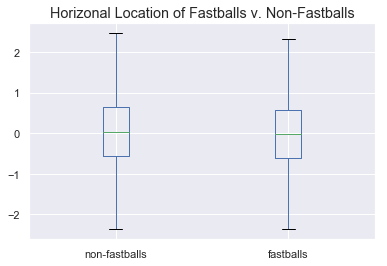

In [39]:
_ = sns.set()
_ = plt.figure(figsize=(14,4))
_ = df[['fastball', 'px']].boxplot(by = 'fastball', showfliers=False).set_xticklabels(['non-fastballs', 'fastballs'])
_ = plt.title('Horizonal Location of Fastballs v. Non-Fastballs', size='large')
_ = plt.xlabel(None)
_ = plt.ylabel(None)
_ = plt.suptitle(None)

In [40]:
# Calculating mean/median/std of each dataset
calculate_stats(df['px'], df_fastball['px'], df_nofastball['px'])

all pitches mean = 0.0065725019675674946
all pitches median = 0.007660961113344931
all pitches std = 0.890537096683178
fastballs mean = -0.022860163488148226
fastballs median = -0.018000000000000002
fastballs std = 0.8454364743652532
non-fastballs mean = 0.03898346746388044
non-fastballs median = 0.0368679520389319
non-fastballs std = 0.9366258261381617


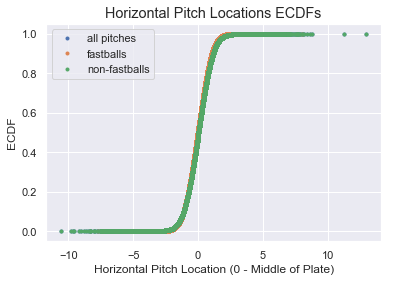

In [41]:
# Comparing the Empirical Cumulative Distribution Function (ECDF) for each of the datasets
graph_ecdfs('px', 'Horizontal Pitch Location (0 - Middle of Plate)', 'Horizontal Pitch Locations ECDFs')

#### Vertical Pitch Location

<Figure size 1008x288 with 0 Axes>

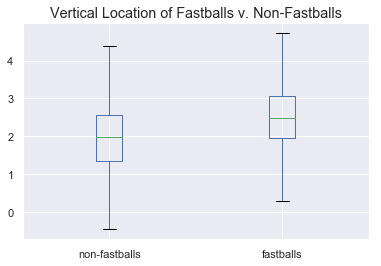

In [42]:
_ = sns.set()
_ = plt.figure(figsize=(14,4))
_ = df[['fastball', 'pz']].boxplot(by = 'fastball', showfliers=False).set_xticklabels(['non-fastballs', 'fastballs'])
_ = plt.title('Vertical Location of Fastballs v. Non-Fastballs', size='large')
_ = plt.xlabel(None)
_ = plt.ylabel(None)
_ = plt.suptitle(None)

In [43]:
# Calculating mean/median/std of each dataset
calculate_stats(df['pz'], df_fastball['pz'], df_nofastball['pz'])

all pitches mean = 2.2549622540482397
all pitches median = 2.2549622540477583
all pitches std = 0.944051941946748
fastballs mean = 2.51341692816395
fastballs median = 2.4940568676534047
fastballs std = 0.8512426889047401
non-fastballs mean = 1.9703544757355749
non-fastballs median = 1.9809999999999999
non-fastballs std = 0.9592468642801323


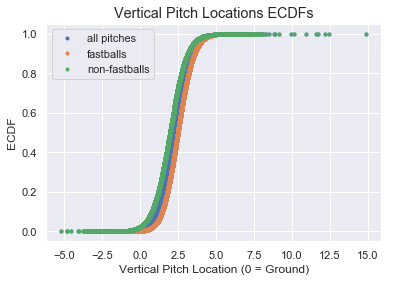

In [44]:
# Comparing the Empirical Cumulative Distribution Function (ECDF) for each of the datasets
graph_ecdfs('pz', 'Vertical Pitch Location (0 = Ground)', 'Vertical Pitch Locations ECDFs')

#### Pitch Spin Rate

<Figure size 1008x288 with 0 Axes>

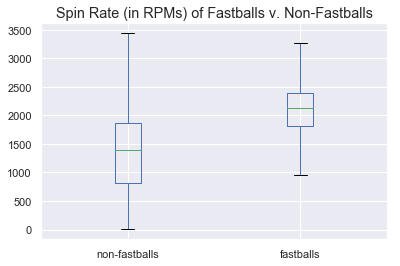

In [45]:
_ = sns.set()
_ = plt.figure(figsize=(14,4))
_ = df[['fastball', 'spin_rate']].boxplot(by = 'fastball', showfliers=False).set_xticklabels(['non-fastballs', 'fastballs'])
_ = plt.title('Spin Rate (in RPMs) of Fastballs v. Non-Fastballs', size='large')
_ = plt.xlabel(None)
_ = plt.ylabel(None)
_ = plt.suptitle(None)

In [46]:
# Calculating mean/median/std of each dataset
calculate_stats(df['spin_rate'], df_fastball['spin_rate'], df_nofastball['spin_rate'])

all pitches mean = 1731.1728888285434
all pitches median = 1862.01
all pitches std = 681.0605246780085
fastballs mean = 2061.337168650513
fastballs median = 2135.9885
fastballs std = 515.2406905419363
non-fastballs mean = 1367.5991888009219
non-fastballs median = 1389.0535
non-fastballs std = 655.7912694299469


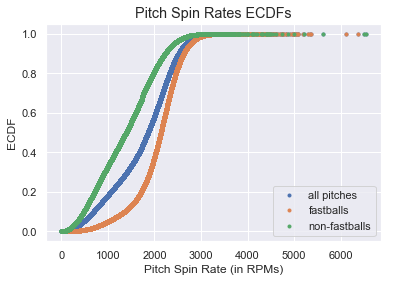

In [47]:
# Comparing the Empirical Cumulative Distribution Function (ECDF) for each of the datasets
graph_ecdfs('spin_rate', 'Pitch Spin Rate (in RPMs)', 'Pitch Spin Rates ECDFs')

#### Pitch Spin Direction

<Figure size 1008x288 with 0 Axes>

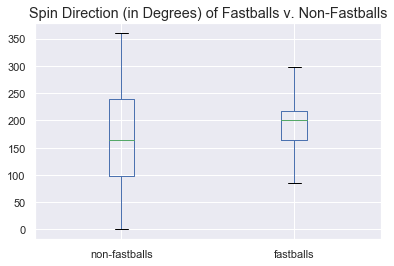

In [51]:
_ = sns.set()
_ = plt.figure(figsize=(14,4))
_ = df[['fastball', 'spin_dir']].boxplot(by = 'fastball', showfliers=False).set_xticklabels(['non-fastballs', 'fastballs'])
_ = plt.title('Spin Direction (in Degrees) of Fastballs v. Non-Fastballs', size='large')
_ = plt.xlabel(None)
_ = plt.ylabel(None)
_ = plt.suptitle(None)

In [52]:
# Calculating mean/median/std of each dataset
calculate_stats(df['spin_dir'], df_fastball['spin_dir'], df_nofastball['spin_dir'])

all pitches mean = 180.23080641505635
all pitches median = 195.5225
all pitches std = 67.26152804316551
fastballs mean = 191.99413934964872
fastballs median = 200.666
fastballs std = 35.92310844296713
non-fastballs mean = 167.27713837442676
non-fastballs median = 163.722
non-fastballs std = 88.11806903315096


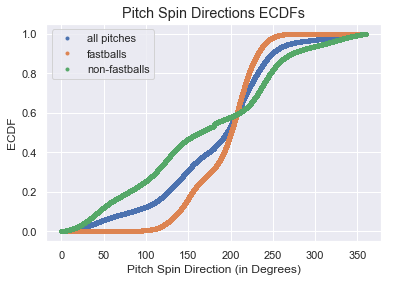

In [53]:
# Comparing the Empirical Cumulative Distribution Function (ECDF) for each of the datasets
graph_ecdfs('spin_dir', 'Pitch Spin Direction (in Degrees)', 'Pitch Spin Directions ECDFs')

As we can see from the simple mean/median/std calculations and graphically, all of the continuous variables analyzed are statistically significant to determining whether a pitch is a fastball without the need for any permutation or boostrap hypothesis testing. This makes sense when considering that the dataset contains observations of nearly 3 million pitches. With that many data points in the observed dataset, we should expect each variable to converge on, or very close to, its true mean and standard deviation. Therefore, even the slightest variations in the variables between fastballs and non-fastballs are likely to be indicative of a truly significant difference.

The issue, of course, is that all of this data is largely unhelpful for the direct purpose of my model given that we do not receive this information until after the pitch has been thrown.  In other words, it is too late to be helpful for the current pitch.  However, it is still valuable to know that we almost instantly can classify a pitch as a certain type once it is thrown.  We may be able to use this data to tell our model information about the previous pitch thrown to see if that information is predictive of the next pitch.

### Categorical Variables

The categorical variables in the dataset are the most important because, unlike the continuous variables discussed above, they are known prior to the pitch being thrown.  In order to accurately evaluate the various categorical variables, I first need to identify a default baseline percentage regarding how often a pitcher throws a fastball. This can be done by calculating the percentage of pitches that are labeled as a `fastball` in the entire dataset:

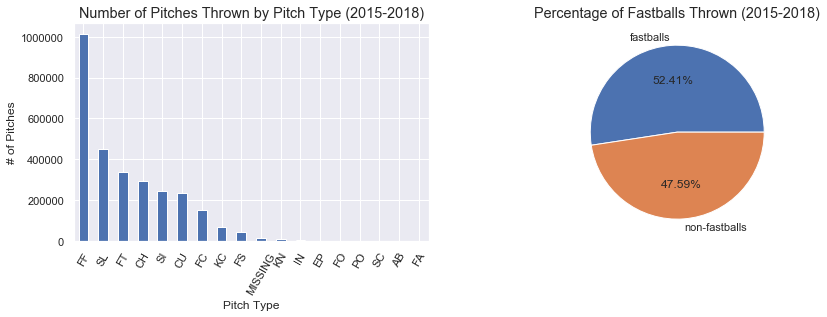

In [54]:
_ = sns.set()
_ = plt.figure(figsize=(14,4))
_ = plt.subplot(1,2,1)
_ = df['pitch_type'].value_counts().plot.bar()
_ = plt.title('Number of Pitches Thrown by Pitch Type (2015-2018)', size='large')
_ = plt.xlabel('Pitch Type')
_ = plt.ylabel('# of Pitches')
_ = plt.xticks(rotation=60)

_ = plt.subplot(1,2,2)
_ = df['fastball'].value_counts().plot.pie(labels=['fastballs', 'non-fastballs'], autopct='%.2f%%')
_ = plt.title('Percentage of Fastballs Thrown (2015-2018)', size='large')
_ = plt.ylabel(None)

As we can see, a pitcher threw a four-seam, two-seam, or cut-fastball approximately 52.41% of the time.  I can use this number as a baseline when analyzing the various categorical data variables. A variable is not overly significant to the extent that it correlates to a fastball usage at or around that same 52.41% frequency - the goal is to identify the circumstances in which that frequency increases (or decreases) materially from that baseline number.

#### Runners on Base

In [56]:
# Dividing the data up based on runners on base
df_norunner = df[(df['on_1b'] == 0) & (df['on_2b'] == 0) & (df['on_3b'] == 0)]
df_on_1b = df[(df['on_1b'] == 1) & (df['on_2b'] == 0) & (df['on_3b'] == 0)]
df_on_2b = df[(df['on_1b'] == 0) & (df['on_2b'] == 1) & (df['on_3b'] == 0)]
df_on_3b = df[(df['on_1b'] == 0) & (df['on_2b'] == 0) & (df['on_3b'] == 1)]
df_on_1b2b = df[(df['on_1b'] == 1) & (df['on_2b'] == 1) & (df['on_3b'] == 0)]
df_on_1b3b = df[(df['on_1b'] == 1) & (df['on_2b'] == 0) & (df['on_3b'] == 1)]
df_on_2b3b = df[(df['on_1b'] == 0) & (df['on_2b'] == 1) & (df['on_3b'] == 1)]
df_allrunner = df[(df['on_1b'] == 1) & (df['on_2b'] == 1) & (df['on_3b'] == 1)]

# Calculating the fastball percentage for every scenario
runners_list = [df_norunner, df_on_1b, df_on_2b, df_on_3b, df_on_1b2b, df_on_1b3b, df_on_2b3b, df_allrunner]
runners_data = []
for i in range(len(runners_list)):
    runners_data.append(np.sum(runners_list[i]['fastball']) / len(runners_list[i]))
print(runners_data)

[0.53086799452936229, 0.5460058961258093, 0.4785657024063481, 0.48213605960084832, 0.50518609543248705, 0.5012471291334305, 0.4455758490023885, 0.52722901963201529]


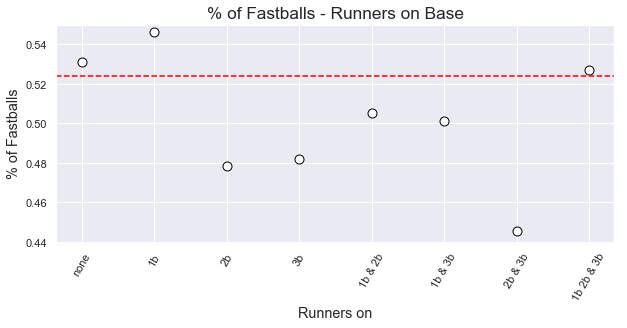

In [57]:
# Graphing the results
_ = sns.set()
_ = plt.figure(figsize=(10,4))
_ = plt.plot(np.arange(len(runners_data)), runners_data, marker='o', linestyle='none', ms=9, mfc='white', mec='black')
_ = plt.title('% of Fastballs - Runners on Base', size='x-large')
_ = plt.xlabel('Runners on', size='large')
_ = plt.ylabel('% of Fastballs', size='large')
_ = plt.xticks(np.arange(len(runners_data)), ['none', '1b', '2b', '3b', '1b & 2b', '1b & 3b', '2b & 3b', '1b 2b & 3b'], rotation=60)
_ = plt.axhline(.5241, color='red', linestyle='--')
_ = plt.ylim((.44, .55))

It appears that the most significant influence on fastball usage is whether there is at least one runner in scoring position (on second or third base).  Interestingly, however, the fastball usage spikes back up to above average when the bases are loaded, likely because a walk in those circumstances results in a run scored.

#### Batting Count

In [58]:
# Dividing the data based on batting count
df_0_0 = df[(df['b_count'] == 0) & (df['s_count'] == 0)]
df_0_1 = df[(df['b_count'] == 0) & (df['s_count'] == 1)]
df_0_2 = df[(df['b_count'] == 0) & (df['s_count'] == 2)]
df_1_0 = df[(df['b_count'] == 1) & (df['s_count'] == 0)]
df_1_1 = df[(df['b_count'] == 1) & (df['s_count'] == 1)]
df_1_2 = df[(df['b_count'] == 1) & (df['s_count'] == 2)]
df_2_0 = df[(df['b_count'] == 2) & (df['s_count'] == 0)]
df_2_1 = df[(df['b_count'] == 2) & (df['s_count'] == 1)]
df_2_2 = df[(df['b_count'] == 2) & (df['s_count'] == 2)]
df_3_0 = df[(df['b_count'] == 3) & (df['s_count'] == 0)]
df_3_1 = df[(df['b_count'] == 3) & (df['s_count'] == 1)]
df_3_2 = df[(df['b_count'] == 3) & (df['s_count'] == 2)]

# Calculating the fastball percentage for every scenario
count_list = [df_0_0, df_0_1, df_0_2, df_1_0, df_1_1, df_1_2, df_2_0, df_2_1, df_2_2, df_3_0, df_3_1, df_3_2]
count_data = []
for i in range(len(count_list)):
    count_data.append(np.sum(count_list[i]['fastball']) / len(count_list[i]))
print(count_data)

[0.55815605998586948, 0.48348919676952473, 0.45932137412008955, 0.54695891951957309, 0.47945308365908201, 0.43763231464884522, 0.64515048189684054, 0.55715351157986448, 0.46801969351213957, 0.73835669434276696, 0.70671894096919097, 0.58476357772274379]


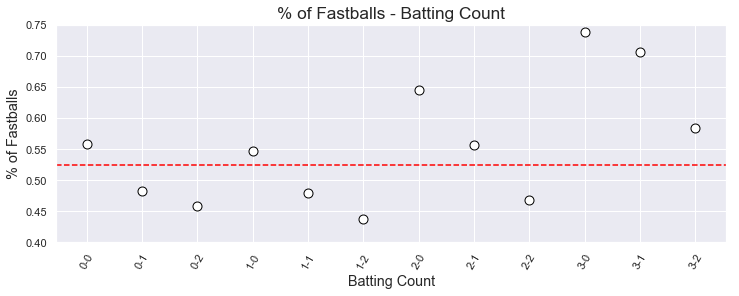

In [59]:
# Graphing the results
_ = sns.set()
_ = plt.figure(figsize=(12,4))
_ = plt.plot(np.arange(len(count_data)), count_data, marker='o', linestyle='none', ms=9, mfc='white', mec='black')
_ = plt.title('% of Fastballs - Batting Count', size='x-large')
_ = plt.xlabel('Batting Count', size='large')
_ = plt.ylabel('% of Fastballs', size='large')
_ = plt.xticks(np.arange(len(count_data)), ['0-0', '0-1', '0-2', '1-0', '1-1', '1-2', '2-0', '2-1', '2-2', '3-0', '3-1', '3-2'], rotation=60)
_ = plt.axhline(.5241, color='red', linestyle='--')
_ = plt.ylim((.40, .75))

It appears that a pitcher's fastball usage decreases when he is ahead in the count and increases when he is behind in the count (likely because he needs to try to avoid walking the batter).

#### Number of Outs

In [60]:
# Dividing the data based on number of outs
df_0outs = df[df['outs'] == 0]
df_1outs = df[df['outs'] == 1]
df_2outs = df[df['outs'] == 2]

# Calculating the fastball percentages for every scenario
outs_list = [df_0outs, df_1outs, df_2outs]
outs_data = []
for i in range(len(outs_list)):
    outs_data.append(np.sum(outs_list[i]['fastball']) / len(outs_list[i]))
print(outs_data)

[0.54381150037267556, 0.51983792459283817, 0.50760966204274005]


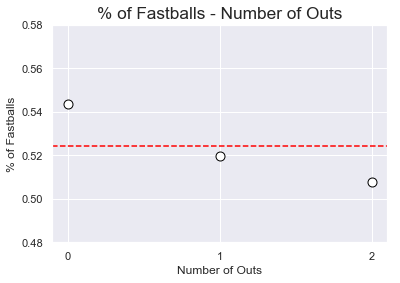

In [61]:
# Graphing the results
_ = sns.set()
_ = plt.figure(figsize=(6,4))
_ = plt.plot(np.arange(len(outs_data)), outs_data, marker='o', linestyle='none', ms=9, mfc='white', mec='black')
_ = plt.title('% of Fastballs - Number of Outs', size='x-large')
_ = plt.xlabel('Number of Outs')
_ = plt.ylabel('% of Fastballs')
_ = plt.xticks(np.arange(len(outs_data)), ['0', '1', '2'])
_ = plt.axhline(.5241, color='red', linestyle='--')
_ = plt.ylim((.48, .58))

Fastball usage appears to decrease depending upon the number of outs.

#### Pitch Sequence

In [62]:
# Dividing the data by pitch sequence
df_pitch1 = df[df['pitch_num'] == 1]
df_pitch2 = df[df['pitch_num'] == 2]
df_pitch3 = df[df['pitch_num'] == 3]
df_pitch4 = df[df['pitch_num'] == 4]
df_pitch5 = df[df['pitch_num'] == 5]
df_pitch6 = df[df['pitch_num'] == 6]
df_pitch7plus = df[df['pitch_num'] > 6]

# Calculating the fastball percentage for each pitch
pitch_list = [df_pitch1, df_pitch2, df_pitch3, df_pitch4, df_pitch5, df_pitch6, df_pitch7plus]
pitch_data = []
for i in range(len(pitch_list)):
    pitch_data.append(np.sum(pitch_list[i]['fastball']) / len(pitch_list[i]))
print(pitch_data)

[0.55815605998586948, 0.51159456606753684, 0.50673537638219845, 0.50739009692966885, 0.51778212035701443, 0.52003410645891068, 0.54035918083002943]


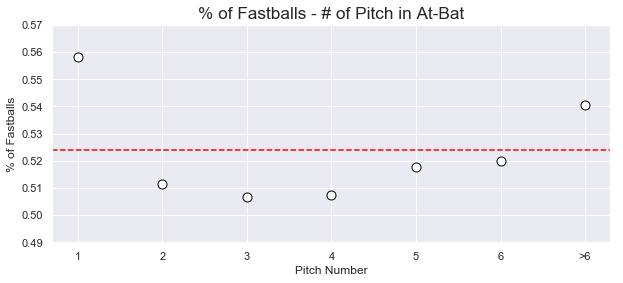

In [63]:
# Graphing the results
_ = sns.set()
_ = plt.figure(figsize=(10,4))
_ = plt.plot(np.arange(len(pitch_data)), pitch_data, marker='o', linestyle='none', ms=9, mfc='white', mec='black')
_ = plt.title('% of Fastballs - # of Pitch in At-Bat', size='x-large')
_ = plt.xlabel('Pitch Number')
_ = plt.ylabel('% of Fastballs')
_ = plt.xticks(np.arange(len(pitch_data)), ['1', '2', '3', '4', '5', '6', '>6'])
_ = plt.axhline(.5241, color='red', linestyle='--')
_ = plt.ylim((.49, .57))

It appears that pitchers throw more than average amounts of fastballs by a considerable amount on the first pitch of an at-bat and any pitch after the sixth pitch in a long at-bat.   

#### Inning

In [17]:
# Dividing the data by inning
df_first = df[df['inning'] == 1]
df_second = df[df['inning'] == 2]
df_third = df[df['inning'] == 3]
df_fourth = df[df['inning'] == 4]
df_fifth = df[df['inning'] == 5]
df_sixth = df[df['inning'] == 6]
df_seventh = df[df['inning'] == 7]
df_eighth = df[df['inning'] == 8]
df_ninth = df[df['inning'] == 9]
df_extra = df[df['inning'] > 9]

# Calculating the fastball percentage for each inning
inning_list = [df_first, df_second, df_third, df_fourth, df_fifth, df_sixth, df_seventh, df_eighth, df_ninth, df_extra]
inning_data = []
for i in range(len(inning_list)):
    inning_data.append(np.sum(inning_list[i]['fastball']) / len(inning_list[i]))
print(inning_data)

[0.58602136017309003, 0.54601993581915764, 0.51732048417837351, 0.49899914212181873, 0.50073934753767191, 0.49816204051012752, 0.51347054860233554, 0.52169509216283905, 0.53914277186512338, 0.5006379728636895]


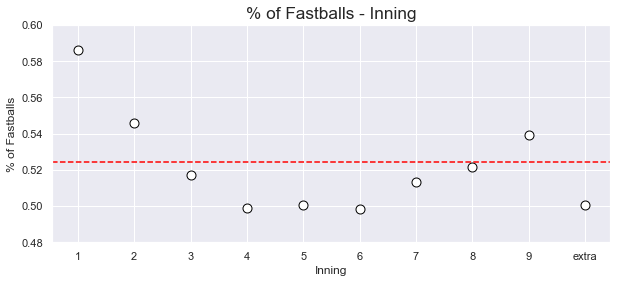

In [18]:
# Graphing the results
_ = sns.set()
_ = plt.figure(figsize=(10,4))
_ = plt.plot(np.arange(len(inning_data)), inning_data, marker='o', linestyle='none', ms=9, mfc='white', mec='black')
_ = plt.title('% of Fastballs - Inning', size='x-large')
_ = plt.xlabel('Inning')
_ = plt.ylabel('% of Fastballs')
_ = plt.xticks(np.arange(len(inning_data)), ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'extra'])
_ = plt.axhline(.5241, color='red', linestyle='--')
_ = plt.ylim((.48, .60))

It appears that fastballs are thrown higher than average in the early innings and the ninth inning.  The middle innings appear to be when the least amount of fastballs are thrown.

#### Pitcher/Batter Dominant Hand

In [20]:
# Dividing the data based on pitcher and batter handedness
df_RvR = df[(df['p_throws'] == 'R') & (df['stand'] == 'R')]
df_LvR = df[(df['p_throws'] == 'L') & (df['stand'] == 'R')]
df_RvL = df[(df['p_throws'] == 'R') & (df['stand'] == 'L')]
df_LvL = df[(df['p_throws'] == 'L') & (df['stand'] == 'L')]

# Calculate the fastball percentage for each circumstance
PvB_list = [df_RvR, df_LvR, df_RvL, df_LvL]
PvB_data = []
for i in range(len(PvB_list)):
    PvB_data.append(np.sum(PvB_list[i]['fastball']) / len(PvB_list[i]))
print(PvB_data)

[0.52710910954392154, 0.50966883141613062, 0.53277793410585361, 0.50568841314000401]


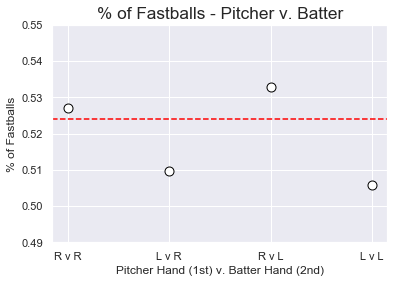

In [21]:
# Graphing the results
_ = sns.set()
_ = plt.figure(figsize=(6,4))
_ = plt.plot(np.arange(len(PvB_data)), PvB_data, marker='o', linestyle='none', ms=9, mfc='white', mec='black')
_ = plt.title('% of Fastballs - Pitcher v. Batter', size='x-large')
_ = plt.xlabel('Pitcher Hand (1st) v. Batter Hand (2nd)')
_ = plt.ylabel('% of Fastballs')
_ = plt.xticks(np.arange(len(PvB_data)), ['R v R', 'L v R', 'R v L', 'L v L'])
_ = plt.axhline(.5241, color='red', linestyle='--')
_ = plt.ylim((.49, .55))

It appears that right-handed pitchers throw fastballs more often than left-handed pitchers regardless of the handedness of the batter.

#### Game Score

In [22]:
# Dividing the data based on game score
df_tie = df[(df['p_score'] - df['b_score']) == 0]
df_pitcher1 = df[(df['p_score'] - df['b_score']) == 1]
df_pitcher2 = df[(df['p_score'] - df['b_score']) == 2]
df_pitcher3 = df[(df['p_score'] - df['b_score']) == 3]
df_pitcher4 = df[(df['p_score'] - df['b_score']) == 4]
df_pitcher5 = df[(df['p_score'] - df['b_score']) == 5]
df_pitcher6 = df[(df['p_score'] - df['b_score']) == 6]
df_pitcher7 = df[(df['p_score'] - df['b_score']) == 7]
df_pitcher8 = df[(df['p_score'] - df['b_score']) == 8]
df_pitcher9plus = df[(df['p_score'] - df['b_score']) > 8]
df_batter1 = df[(df['b_score'] - df['p_score']) == 1]
df_batter2 = df[(df['b_score'] - df['p_score']) == 2]
df_batter3 = df[(df['b_score'] - df['p_score']) == 3]
df_batter4 = df[(df['b_score'] - df['p_score']) == 4]
df_batter5 = df[(df['b_score'] - df['p_score']) == 5]
df_batter6 = df[(df['b_score'] - df['p_score']) == 6]
df_batter7 = df[(df['b_score'] - df['p_score']) == 7]
df_batter8 = df[(df['b_score'] - df['p_score']) == 8]
df_batter9plus = df[(df['b_score'] - df['p_score']) > 8]

# Calculating the fastball percentage for each score
score_list = [df_pitcher9plus, df_pitcher8, df_pitcher7, df_pitcher6, df_pitcher5, df_pitcher4, df_pitcher3, df_pitcher2, df_pitcher1, df_tie, df_batter1, df_batter2, df_batter3, df_batter4, df_batter5, df_batter6, df_batter7, df_batter8, df_batter9plus]
score_data = []
for i in range(len(score_list)):
    score_data.append(np.sum(score_list[i]['fastball']) / len(score_list[i]))
print(score_data)

[0.55555898036556417, 0.54266279883965185, 0.53779787677603519, 0.53549848942598188, 0.53353558093564679, 0.53543265084769875, 0.53353777772259714, 0.52850056784020305, 0.52585502475926482, 0.54121982380410005, 0.50921017815552194, 0.5001362339818638, 0.49628746200900242, 0.50255799349881791, 0.51092482193177469, 0.50148450946643719, 0.50920472520445592, 0.50147026791548677, 0.51113211852527951]


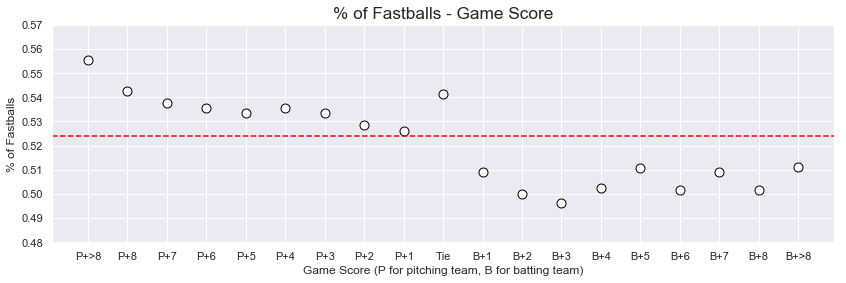

In [25]:
# Graphing the results
_ = sns.set()
_ = plt.figure(figsize=(14,4))
_ = plt.plot(np.arange(len(score_data)), score_data, marker='o', linestyle='none', ms=9, mfc='white', mec='black')
_ = plt.title('% of Fastballs - Game Score', size='x-large')
_ = plt.xlabel('Game Score (P for pitching team, B for batting team)')
_ = plt.ylabel('% of Fastballs')
_ = plt.xticks(np.arange(len(score_data)), ['P+>8', 'P+8', 'P+7', 'P+6', 'P+5', 'P+4', 'P+3', 'P+2', 'P+1', 'Tie', 'B+1', 'B+2', 'B+3', 'B+4', 'B+5', 'B+6', 'B+7', 'B+8', 'B+>8'])
_ = plt.axhline(.5241, color='red', linestyle='--')
_ = plt.ylim((.48, .57))

Pitchers appear to throw more fastballs than usual when their team is winning or the game is tied and significantly less fastballs when their team is behind.

In summary, it certainly appears as though some correlation exists between certain game circumstances and the likelihood that a pitcher will throw a fastball on the next pitch.  I therefore am hopeful that a model can predict when a fastball will be thrown at a rate higher than the baseline 52.41 percent.

## Finalizing the Data for Model Formation

Having uncovered enough potential correlation between the data features and the target label through some exploratory data analysis, I now turn to building a machine learning model.  I first need to build a dataframe that is compatible with the various classifier algorithms available.  I will name the new dataframe `df_model`.  Let's first review what features are available in the current dataframe:

In [13]:
df.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,type,pitch_type,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,fastball
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,34.685,-11.960,1.72,3.56,2.0,-6.409,-136.065,-3.995,101.140000,2.280,158.780000,50.0,5.302,4.16,10.93,55.0,3.0,C,S,FF,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,1
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,34.225,-10.085,1.72,3.56,2.0,-8.411,-135.690,-5.980,124.280000,2.119,175.410000,50.0,5.307,6.57,12.00,31.0,5.0,S,S,FF,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,1
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,35.276,-11.560,1.72,3.56,2.0,-9.802,-137.668,-3.337,136.740000,2.127,150.110000,50.0,5.313,7.61,10.88,49.0,1.0,F,S,FF,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,1
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,28.354,-20.540,1.74,3.35,2.0,-8.071,-133.005,-6.567,109.685636,2.279,187.463482,50.0,5.210,1.17,6.45,41.0,13.0,B,B,FF,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,1
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,21.774,-34.111,1.72,3.56,2.0,-6.309,-110.409,0.325,146.527525,2.179,177.242829,50.0,5.557,-8.43,-1.65,18.0,13.0,B,B,CU,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,0


Before adding any features, I will first create the dataframe with the `ab_id` column so that I will be able to track the data if necessary.  I will also add the `fastball` column.  Placing the target label prior to all of the model features will make things easier down the road.  I also will add the runners on base features, as they are binary categorical numerical features (i.e., values of 0 or 1) that can be used as is.

In [14]:
df_model = df.loc[:, ['ab_id', 'fastball', 'on_1b', 'on_2b', 'on_3b']]

### Binary Categorical Features

There are three binary categorical features of interest:
- `p_throws` (whether the pitcher is right or left-handed with values of R and L);
- `stand` (whether the batter is right or left-handed with values of R and L); and
- `top` (whether it is the top or the bottom of the inning with boolean values of True for top and False for bottom).

I will convert these into binary numerical features and add them to the dataframe.

In [15]:
df_model['p_throws_num'] = np.where(df.loc[:, 'p_throws'] == 'R', 1, 0)
df_model['stand_num'] = np.where(df.loc[:, 'stand'] == 'R', 1, 0)
df_model['top_num'] = np.where(df.loc[:, 'top'] == True, 1, 0)

### Multi-Categorical Features

For the multi-catergorical features, I will need to build dummy variables to add to the model dataframe.  I will address each one separately.

### Pitch Number

This features provides the pitch number of each at-bat.  Because any at-bat with 10 or more pitches is rare, we will combine all such instances into one column, get the dummy variables (with the first value dropped), and add them to the model dataframe.

In [16]:
# Convert to int datatype
df['pitch_num'] = df['pitch_num'].astype('int')

# Combine the outlier values into one column
df['pitch_num'] = df['pitch_num'].replace([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 10)

# Create the dummy variables
df_dummies = pd.get_dummies(df['pitch_num'], prefix='pitch_num', drop_first=True)

# Add the dummy variables to the model dataframe
df_model = pd.concat([df_model, df_dummies], axis=1)

### Batting Count - Balls

The values in this column should range from 0-3, but we have a few values of 4.  I will convert those to 3 and then create the dummy variables and add them to the model.

In [17]:
df['b_count'].value_counts()

0.0    1292084
1.0     855623
2.0     483926
3.0     235508
4.0         13
Name: b_count, dtype: int64

In [18]:
# Convert to int datatype
df['b_count'] = df['b_count'].astype('int')

# Replace values of 4 as 3
df['b_count'] = df['b_count'].replace(4, 3)

# Create the dummy variables
df_dummies = pd.get_dummies(df['b_count'], prefix='b_count', drop_first=True)

# Add the dummy variables to the model dataframe
df_model = pd.concat([df_model, df_dummies], axis=1)

### Batting Count - Strikes and Outs

Both of these features need no manipluation, so I will create dummy variables for each and add them to the model dataframe

In [19]:
# Convert s_count to int datatype
df['s_count'] = df['s_count'].astype('int')

# Create the dummy variables
df_dummies = pd.get_dummies(df['s_count'], prefix='s_count', drop_first=True)

# Add the dummy variables to the model dataframe
df_model = pd.concat([df_model, df_dummies], axis=1)

In [20]:
# Convert outs to int datatype
df['outs'] = df['outs'].astype('int')

# Create the dummy variables
df_dummies = pd.get_dummies(df['outs'], prefix='outs', drop_first=True)

# Add the dummy variables to the model dataframe
df_model = pd.concat([df_model, df_dummies], axis=1)

### Inning

Similar to the at-bat pitch count, the inning variable has a few outliers for games that went deep into extra innings.  For the purpose of this analysis, I will group all extra inning games together, build the dummy variables, and add them to the model dataframe.

In [21]:
df['inning'].value_counts()

1     333237
8     323829
7     322073
6     319920
4     318227
2     316917
3     316908
5     315819
9     244579
10     25309
11     14383
12      7560
13      4244
14      1809
15      1076
16       693
17       308
18       191
19        72
Name: inning, dtype: int64

In [22]:
# Combine all extra inning games into one column
df['inning'] = df['inning'].replace([11, 12, 13, 14, 15, 16, 17, 18, 19], 10)

# Create the dummy variables
df_dummies = pd.get_dummies(df['inning'], prefix='inning', drop_first=True)

# Add the dummy variables to the model dataframe
df_model = pd.concat([df_model, df_dummies], axis=1)

### Pitcher Score and Batter Score

These two features provide the current score for each team for each pitch.  The most efficient way to incorporate this data is to create a new column that provides the difference between the teams' scores.  The outlier scores will also be combined into one column for any spread of 10 or more runs.  Once those calculations are complete, I will create and add the dummy variables to the model dataframe.

In [23]:
# Create the new difference in score column
df['pitcher_lead'] = df['p_score'] - df['b_score']

# Combine the outlier score differences
df['pitcher_lead'] = df['pitcher_lead'].replace([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24], 10).astype('int')
df['pitcher_lead'] = df['pitcher_lead'].replace([-11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -23, -24], -10).astype('int')

# Create the dummy variables
df_dummies = pd.get_dummies(df['pitcher_lead'], prefix='pitcher_lead', drop_first=True)

# Add the dummy variables to the model dataframe
df_model = pd.concat([df_model, df_dummies], axis=1)

Let's review the new model dataframe as it currently stands:

In [24]:
df_model.head()

,ab_id,fastball,on_1b,on_2b,on_3b,p_throws_num,stand_num,top_num,pitch_num_2,pitch_num_3,pitch_num_4,pitch_num_5,pitch_num_6,pitch_num_7,pitch_num_8,pitch_num_9,pitch_num_10,b_count_1,b_count_2,b_count_3,s_count_1,s_count_2,outs_1,outs_2,inning_2,inning_3,inning_4,inning_5,inning_6,inning_7,inning_8,inning_9,inning_10,pitcher_lead_-9,pitcher_lead_-8,pitcher_lead_-7,pitcher_lead_-6,pitcher_lead_-5,pitcher_lead_-4,pitcher_lead_-3,pitcher_lead_-2,pitcher_lead_-1,pitcher_lead_0,pitcher_lead_1,pitcher_lead_2,pitcher_lead_3,pitcher_lead_4,pitcher_lead_5,pitcher_lead_6,pitcher_lead_7,pitcher_lead_8,pitcher_lead_9,pitcher_lead_10
0,2.015000e+09,1,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2.015000e+09,1,0.0,0.0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2.015000e+09,1,0.0,0.0,0.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,2.015000e+09,1,0.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,2.015000e+09,0,0.0,0.0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [25]:
df_model.shape

(2867154, 53)

We currently have over 50 features based on our pre-pitch information.  I think its time to feed this data into a few default classifiers and see what the initial results are!

## Machine Learning Model Test Run

The biggest obstacle to overcome when building models is computational speed.  Our dataframe contains over 2.8 million pitches, which simply would take too long to use for every iteration of model training.  So, to build our models, I will use a sample of 145,000 pitches (roughly 5% of the samples).

In [26]:
# create the sample dataframe
df_sample = df_model.sample(145000, random_state=6)

# verify the fastball/non-fastball split
df_sample['fastball'].sum() / len(df_sample)

0.52404827586206892

It looks like our sample database has 52.404% fastballs, which is matches up favorably to the 52.41% split in the entire database.  Next, we can split the sample dataframe into the target label (y) and the features (X), and then split the data into train and test sets using `train_test_split`:

In [28]:
# split the dataframe
X = df_sample.iloc[:, 2:]
y = df_sample.iloc[:, 1]

# split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6, stratify=y)

Now I can build a few different classifiers using their default settings to see some initial results:

### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(lr.score(X_test, y_test))

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.551117241379


### SGDClassifier

In [30]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier()
sgdc.fit(X_train, y_train)
y_pred_sgdc = sgdc.predict(X_test)
print(sgdc.score(X_test, y_test))

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.543834482759


### Random Forest Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print(rfc.score(X_test, y_test))

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.526731034483


As you can see, the default models perform only marginally better than the default 52.41% accuracy you could achieve simply by guessing fastball everytime.  So, I will need to see if there is anything that can be done to improve the accuracy of the models.  As a first step, I am going to build some additional features to be added to the dataframe based on previous pitch information.

## Adding Previous Pitch Features

I am fairly confident that information about the previous pitch in a pitch sequence should improve the accuracy of my models.  The major obstacle to this approach is that it will involve having to iterate over the samples, which is computationally expensive (i.e., time-consuming) given that there are over 2.8 million pitches.  I ultimately decided to add the following features:

### Inning Pitch Count

I ended up determining that I could calculate a pitcher's pitch-count for each inning thinking that pitch usage patterns may be influenced depending on how many pitches a pitcher has thrown in a particular inning.  It would have been much more difficult to build a total pitch count for each pitcher for each game given the way the data was organized.  I ended up building a function and using the `apply()` method to speed up the computation. (WARNING - THIS CODE TAKES A LONG TIME TO RUN)

In [ ]:
# add the pitcher_id column
df_model['pitcher_id'] = df.loc[:, 'pitcher_id']

# build the function
def inning_pitch_count(df):
    for index in df.index:
        if index == 0:
            df.loc[index, 'inning_pitch_count'] = 1
        elif df.loc[index, 'pitcher_id'] == df.loc[index-1, 'pitcher_id']:
            df.loc[index, 'inning_pitch_count'] = df.loc[index-1, 'inning_pitch_count'] + 1
        else:
            df.loc[index, 'inning_pitch_count'] = 1

# run the function using the apply() method
df_model['inning_pitch_count'] = df_model.apply(inning_pitch_count(df_model))

# normalize the data because it is a continuous variable
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_model['inning_pitch_count'] = min_max_scaler.fit_transform(df_model.loc[:, 'inning_pitch_count'].values.astype(float))

### Previous Pitch Type/Location

As noted above, the data recorded about each pitch after it was thrown is highly informative about what pitch has been thrown - we could no doubt build a very accurate model using that data.  My hope is by feeding those characteristics about the previous pitch thrown may be indicative of whether a pitcher will throw a fastball in the next pitch.  The issue is that building such features in a 2.8 million pitch dataframe is incredibly time-consuming.  I ultimately decided to generate three new features based off the previous pitch data - the previous pitch type (based on the `pitch_type` label) and the location of the previous pitch (based on the `px` and `pz` values).  My thought is that the other six non-location characteristics are essentially combined into the pitch label because each of those pitches have fairly unique characteristics.

Here is the code I used for this process (WARNING - THIS CODE TAKES A LONG TIME TO RUN).

In [37]:
# create a new dataframe to build the new features
df_prev_pitch = df.loc[:, ['pitch_num', 'pitch_type', 'px', 'pz']]

# shift the pitch_type, px, and pz columns down one row
df_prev_pitch['pitch_type'] = df_prev_pitch['pitch_type'].shift(1, axis=0)
df_prev_pitch['px'] = df_prev_pitch['px'].shift(1, axis=0)
df_prev_pitch['pz'] = df_prev_pitch['pz'].shift(1, axis=0)

# add the new feature columns
df_prev_pitch['pitch_type_prev'] = 0
df_prev_pitch['px_prev'] = 0
df_prev_pitch['pz_prev'] = 0

df_prev_pitch.head()

,pitch_num,pitch_type,px,pz,pitch_type_prev,px_prev,pz_prev
0,1,NaN,NaN,NaN,0,0,0
1,2,FF,0.416,2.963,0,0,0
2,3,FF,-0.191,2.347,0,0,0
3,4,FF,-0.518,3.284,0,0,0
4,5,FF,-0.641,1.221,0,0,0


In [ ]:
# build the function
def prev_pitch(df):
    for row in df.index:
        if df.loc[row, 'pitch_num'] > 1:
            df.loc[row, 'pitch_type_prev'] = df.loc[row, 'pitch_type']
            df.loc[row, 'px_prev'] = df.loc[row, 'px']
            df.loc[row, 'pz_prev'] = df.loc[row, 'pz']
            
# run the function using the apply() method (WARINING - THIS FUNCTION TAKES A LONG TIME TO RUN)
df_prev_pitch = df_prev_pitch.apply(lambda x: prev_pitch(df_prev_pitch), axis=1)

Once the new features are built, we need to create dummy variables for the `pitch_type_prev` columns, drop the unneeded values, and then add them to model dataframe:

In [ ]:
# get dummy variables
df_dummies = pd.get_dummies(df_prev_pitch['pitch_type_prev'], prefix='prev_pitch')

# delete the unneeded dummy variables
del df_dummies['prev_pitch_0']
del df_dummies['prev_pitch_MISSING']

# add the dummy variables to the model dataframe
df_model = pd.concat([df_model, df_dummies], axis=1)

Finally, we need to add the `px_prev` and `pz_prev` features to the model dataframe.  While these variables are continuous, we need to convert them to categorical features because we need the model to understand that the first pitch of every pitch sequence has no previous pitch location at all (right now those values are 0, which the model would interpret as a horizontal and vertical location.

To do this, I will first replace the default numerical values that we previously used during exploratory data analysis (the mean values for the samples where location was missing and 0 for the first pitch of every at-bat).  Then, I will consolidate the outlier values so that we get a more meaningful distribution once we divide the values into categorical bins.  Then, I will convert the values into 15 bins using `pd.cut()`.  Then, I will create dummy variables for each bin and add those to the model dataframe (the `NaN` values will be dropped during the creation of dummy variables).

#### px_prev:

In [ ]:
# replace the missing and zero values with NaNs
df_prev_pitch['px_prev'] = df_prev_pitch['px_prev'].replace(0.000000, np.nan)
df_prev_pitch['px_prev'] = df_prev_pitch['px_prev'].replace(0.006600, np.nan)

# create dataframe of only outlier values and use that dataframe index to iterate and convert values in df_prev_pitch
df_outlier = df_prev_pitch[df_prev_pitch['px_prev'] > 4]
for row in df_outlier.index:
    df_prev_pitch.loc[row, 'px_prev'] = 4

df_outlier = df_prev_pitch[df_prev_pitch['px_prev'] < -4]
for row in df_outlier.index:
    df_prev_pitch.loc[row, 'px_prev'] = -4

# divide px_prev values into 15 bins
df_prev_pitch['px_prev'] = pd.cut(df_prev_pitch['px_prev'], 15)

# create dummy variables [NOTE - pd.get_dummies automatically drops NaN values]
df_dummies = pd.get_dummies(df_prev_pitch['px_prev'], prefix='px_prev')

# add dummy variables to model dataframe
df_model = pd.concat([df_model, df_dummies], axis=1)

#### pz_prev:

In [ ]:
# replace the missing and zero values with NaNs
df_prev_pitch['pz_prev'] = df_prev_pitch['pz_prev'].replace(0.000000, np.nan)
df_prev_pitch['pz_prev'] = df_prev_pitch['pz_prev'].replace(2.250000, np.nan)

# create dataframe of only outlier values and use that dataframe index to iterate and convert values in df_prev_pitch
df_outlier = df_prev_pitch[df_prev_pitch['pz_prev'] > 5]
for row in df_outlier.index:
    df_prev_pitch.loc[row, 'pz_prev'] = 5

df_outlier = df_prev_pitch[df_prev_pitch['pz_prev'] < -1]
for row in df_outlier.index:
    df_prev_pitch.loc[row, 'pz_prev'] = -1

# divide pz_prev values into 15 bins
df_prev_pitch['pz_prev'] = pd.cut(df_prev_pitch['pz_prev'], 15)

# create dummy variables [NOTE - pd.get_dummies automatically drops NaN values]
df_dummies = pd.get_dummies(df_prev_pitch['pz_prev'], prefix='pz_prev')

# add dummy variables to model dataframe
df_model = pd.concat([df_model, df_dummies], axis=1)

## Machine Learning Model Second Test Run 

Now that I have added some previous pitch features, I will re-rerun the data through the default classifiers to see if the accuracy improves.

NOTE - because it takes a long time to build the previous pitch features, I will be loading a `.csv` file from my local drive with those features already incorporated.

In [3]:
df_model = pd.read_csv('df_model_final.csv', index_col=0)

C:\Users\Owner\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df_model.head()

,ab_id,fastball,inning_pitch_count,on_1b,on_2b,on_3b,p_throws_num,stand_num,top_num,pitch_num_2,pitch_num_3,pitch_num_4,pitch_num_5,pitch_num_6,pitch_num_7,pitch_num_8,pitch_num_9,pitch_num_10,b_count_1,b_count_2,b_count_3,s_count_1,s_count_2,outs_1,outs_2,inning_2,inning_3,inning_4,inning_5,inning_6,inning_7,inning_8,inning_9,inning_10,pitcher_lead_-10,pitcher_lead_-9,pitcher_lead_-8,pitcher_lead_-7,pitcher_lead_-6,pitcher_lead_-5,pitcher_lead_-4,pitcher_lead_-3,pitcher_lead_-2,pitcher_lead_-1,pitcher_lead_1,pitcher_lead_2,pitcher_lead_3,pitcher_lead_4,pitcher_lead_5,pitcher_lead_6,pitcher_lead_7,pitcher_lead_8,pitcher_lead_9,pitcher_lead_10,prev_pitch_CH,prev_pitch_CU,prev_pitch_EP,prev_pitch_FC,prev_pitch_FF,prev_pitch_FO,prev_pitch_FS,prev_pitch_FT,prev_pitch_IN,prev_pitch_KC,prev_pitch_KN,prev_pitch_PO,prev_pitch_SC,prev_pitch_SI,prev_pitch_SL,"px_prev_(-4.008, -3.467]","px_prev_(-3.467, -2.933]","px_prev_(-2.933, -2.4]","px_prev_(-2.4, -1.867]","px_prev_(-1.867, -1.333]","px_prev_(-1.333, -0.8]","px_prev_(-0.8, -0.267]","px_prev_(-0.267, 0.267]","px_prev_(0.267, 0.8]","px_prev_(0.8, 1.333]","px_prev_(1.333, 1.867]","px_prev_(1.867, 2.4]","px_prev_(2.4, 2.933]","px_prev_(2.933, 3.467]","px_prev_(3.467, 4.0]","pz_prev_(-1.006, -0.6]","pz_prev_(-0.6, -0.2]","pz_prev_(-0.2, 0.2]","pz_prev_(0.2, 0.6]","pz_prev_(0.6, 1.0]","pz_prev_(1.0, 1.4]","pz_prev_(1.4, 1.8]","pz_prev_(1.8, 2.2]","pz_prev_(2.2, 2.6]","pz_prev_(2.6, 3.0]","pz_prev_(3.0, 3.4]","pz_prev_(3.4, 3.8]","pz_prev_(3.8, 4.2]","pz_prev_(4.2, 4.6]","pz_prev_(4.6, 5.0]"
0,2015000001,1,0.000000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015000001,1,0.018868,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2015000001,1,0.037736,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2015000001,1,0.056604,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2015000001,0,0.075472,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [5]:
df_model.shape

(2867154, 99)

In [4]:
# create the sample dataframe
df_sample = df_model.sample(145000, random_state=6)

# verify the fastball/non-fastball split
df_sample['fastball'].sum() / len(df_sample)

0.52404827586206892

In [5]:
# split the dataframe
X = df_sample.iloc[:, 2:]
y = df_sample.iloc[:, 1]

# split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6, stratify=y)

### Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('Training Set Accuracy: {}'.format(lr.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(lr.score(X_test, y_test)))

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Set Accuracy: 0.6035770114942529
Test Set Accuracy: 0.6015172413793104


### SGDClassifier

In [10]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier()
sgdc.fit(X_train, y_train)
y_pred_sgdc = sgdc.predict(X_test)
print('Training Set Accuracy: {}'.format(sgdc.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(sgdc.score(X_test, y_test)))

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Training Set Accuracy: 0.593103448275862
Test Set Accuracy: 0.5919172413793103


### Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print('Training Set Accuracy: {}'.format(rfc.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(rfc.score(X_test, y_test)))

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Set Accuracy: 0.9470712643678161
Test Set Accuracy: 0.569544827586207


### Gradient Boosting Classifier

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
print('Training Set Accuracy: {}'.format(gbc.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(gbc.score(X_test, y_test)))

Training Set Accuracy: 0.6062988505747127
Test Set Accuracy: 0.601848275862069


It looks as though the previous pitch data and pitch count featuers have improved the overall accuracy of the various models significantly.  I will now try to tune some hyperparameters to see if I can improve the performance even more.

## Hyperparameter Tuning

Of the four classifiers we tested, the logistic regression and gradient boosting classifiers performed the best using their respective default settings, with both achieving an overall accuracy score of over 0.60 on the test set.  I will tune the parameters for each model to see if I can improve performance.

### Logistic Regression

I will first tune the `C` hyperparameter:

In [14]:
from sklearn.linear_model import LogisticRegression
c_list = [0.01, 0.1, 1, 10, 100, 1000, 10000]
for c in c_list:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    print('C value {} Training Set Accuracy: {}'.format(c, lr.score(X_train, y_train)))
    print('C value {} Test Set Accuracy: {}'.format(c, lr.score(X_test, y_test)))


C value 0.01 Training Set Accuracy: 0.6027862068965517
C value 0.01 Test Set Accuracy: 0.6011586206896552
C value 0.1 Training Set Accuracy: 0.6029057471264367
C value 0.1 Test Set Accuracy: 0.6012689655172414
C value 1 Training Set Accuracy: 0.6036137931034483
C value 1 Test Set Accuracy: 0.6014896551724138
C value 10 Training Set Accuracy: 0.603567816091954
C value 10 Test Set Accuracy: 0.6015724137931034
C value 100 Training Set Accuracy: 0.6036229885057471
C value 100 Test Set Accuracy: 0.6016551724137931
C value 1000 Training Set Accuracy: 0.6036413793103448
C value 1000 Test Set Accuracy: 0.6016827586206897
C value 10000 Training Set Accuracy: 0.6036689655172414
C value 10000 Test Set Accuracy: 0.6016275862068966


It appears that a `C` regularization value of 1000 produces the highest accuracy.  Let's tune the `solver` next:

In [10]:
from sklearn.linear_model import LogisticRegression
solver_list = ['liblinear', 'lbfgs']
for solver in solver_list:
    lr = LogisticRegression(C=1000, solver=solver, max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    print('Solver value {} Training Set Accuracy: {}'.format(solver, lr.score(X_train, y_train)))
    print('Solver value {} Test Set Accuracy: {}'.format(solver, lr.score(X_test, y_test)))

Solver value liblinear Training Set Accuracy: 0.6035770114942529
Solver value liblinear Test Set Accuracy: 0.6016
Solver value lbfgs Training Set Accuracy: 0.6036413793103448
Solver value lbfgs Test Set Accuracy: 0.6016827586206897


The default `lbfgs` solver performed best on our dataset (NOTE - the `sag` and `saga` solvers took considerably longer to run with a `C` value of 1000, so I excluded them from consideration for practical reasons).  The`lbfgs` solver only supports a `penalty` of `l2`, so there is no need to tune that parameter.

### Logistic Regression Hyperparameter Tuning Summary

Below is a summary hyperparameter tuning table for the logistic regression model:

In [4]:
df_lr_tune = pd.read_excel('lr_hyperparameters_table.xlsx')
df_lr_tune.sort_values('Test Accuracy', ascending=False)

,Tune,C,Solver,Max_iter,Train Accuracy,Test Accuracy
8,tune_solver,1000.00,lbfgs,1000,0.6036,0.60170
5,tune_C,1000.00,lbfgs,1000,0.6036,0.60168
4,tune_C,100.00,lbfgs,1000,0.6036,0.60165
3,tune_C,10.00,lbfgs,1000,0.6036,0.60160
6,tune_C,10000.00,lbfgs,1000,0.6037,0.60160
7,tune_solver,1000.00,liblinear,1000,0.6036,0.60160
2,tune_C,1.00,lbfgs,1000,0.6036,0.60150
1,tune_C,0.10,lbfgs,1000,0.6029,0.60130
0,tune_C,0.01,lbfgs,1000,0.6027,0.60120


So, I will use the following hyperparamters for the final model:

-  `C`: 1000
-  `Solver`: `lbgfs`

### Gradient Boosting Classifer

The gradient boosting classifier has more hyperparameters to tune, but also is an ensemble classifier that could potentially perform better on the dataset.  I will first tune the `n_estimators` hyperparameter using some placeholder values for the other hyperparameters:

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
n_list = [60, 70, 80, 90, 100]
for n in n_list:
    gbc = GradientBoostingClassifier(n_estimators=n, min_samples_split=750, min_samples_leaf=50, max_depth=8, max_features='sqrt', subsample=0.8, random_state=6)
    gbc.fit(X_train, y_train)
    gbc_pred_lr = gbc.predict(X_test)
    print('N value {} Training Set Accuracy: {}'.format(n, gbc.score(X_train, y_train)))
    print('N value {} Test Set Accuracy: {}'.format(n, gbc.score(X_test, y_test)))

N value 60 Training Set Accuracy: 0.6169287356321839
N value 60 Test Set Accuracy: 0.6035586206896552
N value 70 Training Set Accuracy: 0.6184735632183908
N value 70 Test Set Accuracy: 0.6044137931034482
N value 80 Training Set Accuracy: 0.6208183908045977
N value 80 Test Set Accuracy: 0.6044413793103448
N value 90 Training Set Accuracy: 0.6218022988505747
N value 90 Test Set Accuracy: 0.6045793103448276
N value 100 Training Set Accuracy: 0.6225287356321839
N value 100 Test Set Accuracy: 0.603751724137931


An `n_estimators` value of 90 produced the optimum test set accuracy, so we will move forward with that value.  Next I will tune the `max_depth` hyperparameter: 

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
depth_list = [6, 7, 8, 9, 10]
for depth in depth_list:
    gbc = GradientBoostingClassifier(n_estimators=90, min_samples_split=750, min_samples_leaf=50, max_depth=depth, max_features='sqrt', subsample=0.8, random_state=6)
    gbc.fit(X_train, y_train)
    gbc_pred_lr = gbc.predict(X_test)
    print('Max depth value {} Training Set Accuracy: {}'.format(depth, gbc.score(X_train, y_train)))
    print('Max depth value {} Test Set Accuracy: {}'.format(depth, gbc.score(X_test, y_test)))

Max depth value 6 Training Set Accuracy: 0.6129011494252874
Max depth value 6 Test Set Accuracy: 0.604
Max depth value 7 Training Set Accuracy: 0.6167448275862069
Max depth value 7 Test Set Accuracy: 0.6046344827586206
Max depth value 8 Training Set Accuracy: 0.6218022988505747
Max depth value 8 Test Set Accuracy: 0.6045793103448276
Max depth value 9 Training Set Accuracy: 0.6248091954022988
Max depth value 9 Test Set Accuracy: 0.6051862068965517
Max depth value 10 Training Set Accuracy: 0.6300413793103449
Max depth value 10 Test Set Accuracy: 0.6036689655172414


The training set accuracy increases as we increase the depth, but the test set accuracy peaked at a depth of 9, so we likely should use that value.  I will test the model at max depths 11-13 just to be sure: 

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
depth_list = [11, 12, 13]
for depth in depth_list:
    gbc = GradientBoostingClassifier(n_estimators=90, min_samples_split=750, min_samples_leaf=50, max_depth=depth, max_features='sqrt', subsample=0.8, random_state=6)
    gbc.fit(X_train, y_train)
    gbc_pred_lr = gbc.predict(X_test)
    print('Max depth value {} Training Set Accuracy: {}'.format(depth, gbc.score(X_train, y_train)))
    print('Max depth value {} Test Set Accuracy: {}'.format(depth, gbc.score(X_test, y_test)))

Max depth value 11 Training Set Accuracy: 0.6335264367816092
Max depth value 11 Test Set Accuracy: 0.6042758620689656
Max depth value 12 Training Set Accuracy: 0.6367632183908046
Max depth value 12 Test Set Accuracy: 0.6048827586206896
Max depth value 13 Training Set Accuracy: 0.6393471264367816
Max depth value 13 Test Set Accuracy: 0.6046344827586206


The model continued to overfit as the depth increased without improving the test accuracy, thus confirming that we should move forward with a max depth of 9.  Next, I will tune the `min_samples_split` hyperparameter:

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
split_list = [600, 700, 800, 900, 1000]
for split in split_list:
    gbc = GradientBoostingClassifier(n_estimators=90, min_samples_split=split, min_samples_leaf=50, max_depth=9, max_features='sqrt', subsample=0.8, random_state=6)
    gbc.fit(X_train, y_train)
    gbc_pred_lr = gbc.predict(X_test)
    print('Split value {} Training Set Accuracy: {}'.format(split, gbc.score(X_train, y_train)))
    print('Split value {} Test Set Accuracy: {}'.format(split, gbc.score(X_test, y_test)))

Split value 600 Training Set Accuracy: 0.6252781609195402
Split value 600 Test Set Accuracy: 0.6060137931034483
Split value 700 Training Set Accuracy: 0.6248091954022988
Split value 700 Test Set Accuracy: 0.605351724137931
Split value 800 Training Set Accuracy: 0.6241747126436782
Split value 800 Test Set Accuracy: 0.6059862068965517
Split value 900 Training Set Accuracy: 0.624128735632184
Split value 900 Test Set Accuracy: 0.6032275862068965
Split value 1000 Training Set Accuracy: 0.623687356321839
Split value 1000 Test Set Accuracy: 0.6043862068965518


The optimum `min_samples_split` value was the lowest tested value of 600.  Let's test some lower values:

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
split_list = [500, 400, 300]
for split in split_list:
    gbc = GradientBoostingClassifier(n_estimators=90, min_samples_split=split, min_samples_leaf=50, max_depth=9, max_features='sqrt', subsample=0.8, random_state=6)
    gbc.fit(X_train, y_train)
    gbc_pred_lr = gbc.predict(X_test)
    print('Split value {} Training Set Accuracy: {}'.format(split, gbc.score(X_train, y_train)))
    print('Split value {} Test Set Accuracy: {}'.format(split, gbc.score(X_test, y_test)))

Split value 500 Training Set Accuracy: 0.6265287356321839
Split value 500 Test Set Accuracy: 0.6031172413793103
Split value 400 Training Set Accuracy: 0.6283770114942528
Split value 400 Test Set Accuracy: 0.6025655172413793
Split value 300 Training Set Accuracy: 0.6304091954022989
Split value 300 Test Set Accuracy: 0.6046068965517242


None of these values outperformed a `min_samples_split` value of 600.  We will proceed with 600 as the optimal value, though note that the results at 800 were only marginally worse.  Next, I will tune the `min_samples_leaf` hyperparameter:

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
leaf_list = [35, 40, 45, 50, 55, 60, 65]
for leaf in leaf_list:
    gbc = GradientBoostingClassifier(n_estimators=90, min_samples_split=600, min_samples_leaf=leaf, max_depth=9, max_features='sqrt', subsample=0.8, random_state=6)
    gbc.fit(X_train, y_train)
    gbc_pred_lr = gbc.predict(X_test)
    print('Leaf value {} Training Set Accuracy: {}'.format(leaf, gbc.score(X_train, y_train)))
    print('Leaf value {} Test Set Accuracy: {}'.format(leaf, gbc.score(X_test, y_test)))

Leaf value 35 Training Set Accuracy: 0.6272919540229885
Leaf value 35 Test Set Accuracy: 0.6036413793103448
Leaf value 40 Training Set Accuracy: 0.6262344827586207
Leaf value 40 Test Set Accuracy: 0.6041655172413793
Leaf value 45 Training Set Accuracy: 0.6269609195402299
Leaf value 45 Test Set Accuracy: 0.6039448275862069
Leaf value 50 Training Set Accuracy: 0.6252781609195402
Leaf value 50 Test Set Accuracy: 0.6060137931034483
Leaf value 55 Training Set Accuracy: 0.6261425287356321
Leaf value 55 Test Set Accuracy: 0.6037793103448276
Leaf value 60 Training Set Accuracy: 0.6263724137931035
Leaf value 60 Test Set Accuracy: 0.6054068965517241
Leaf value 65 Training Set Accuracy: 0.6247724137931034
Leaf value 65 Test Set Accuracy: 0.6054068965517241


A `min_samples_leaf` value of 50 outperformed the other values on the test set, though it may be an outlier to the general trend that the model improved as the miminum sample leaf value increased.  Let's try a few more:

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
leaf_list = [70, 75, 80]
for leaf in leaf_list:
    gbc = GradientBoostingClassifier(n_estimators=90, min_samples_split=600, min_samples_leaf=leaf, max_depth=9, max_features='sqrt', subsample=0.8, random_state=6)
    gbc.fit(X_train, y_train)
    gbc_pred_lr = gbc.predict(X_test)
    print('Leaf value {} Training Set Accuracy: {}'.format(leaf, gbc.score(X_train, y_train)))
    print('Leaf value {} Test Set Accuracy: {}'.format(leaf, gbc.score(X_test, y_test)))

Leaf value 70 Training Set Accuracy: 0.6252229885057471
Leaf value 70 Test Set Accuracy: 0.6028137931034483
Leaf value 75 Training Set Accuracy: 0.6237057471264368
Leaf value 75 Test Set Accuracy: 0.6047172413793104
Leaf value 80 Training Set Accuracy: 0.6244689655172414
Leaf value 80 Test Set Accuracy: 0.6046896551724138


The test set accuracy did not increase, so we can move forward with a `min_samples_leaf` value of 50.  Next, I will tune the `max_features` hyperparameter:

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
features_list = [8, 9, 10, 11]
for feature in features_list:
    gbc = GradientBoostingClassifier(n_estimators=90, min_samples_split=600, min_samples_leaf=50, max_depth=9, max_features=feature, subsample=0.8, random_state=6)
    gbc.fit(X_train, y_train)
    gbc_pred_lr = gbc.predict(X_test)
    print('Feature value {} Training Set Accuracy: {}'.format(feature, gbc.score(X_train, y_train)))
    print('Feature value {} Test Set Accuracy: {}'.format(feature, gbc.score(X_test, y_test)))

Feature value 8 Training Set Accuracy: 0.6234390804597701
Feature value 8 Test Set Accuracy: 0.6037793103448276
Feature value 9 Training Set Accuracy: 0.6252781609195402
Feature value 9 Test Set Accuracy: 0.6060137931034483
Feature value 10 Training Set Accuracy: 0.6278436781609196
Feature value 10 Test Set Accuracy: 0.6049379310344828
Feature value 11 Training Set Accuracy: 0.627880459770115
Feature value 11 Test Set Accuracy: 0.6048275862068966


It looks like 9 is the optimum value for `max_features`, which makes sense because that is approximately the value of the square root of the number of features in our model.  Now we can tune the `subsample` hyperparameter:

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
subsample_list = [0.7, 0.75, 0.8, 0.85, 0.9]
for subsample in subsample_list:
    gbc = GradientBoostingClassifier(n_estimators=90, min_samples_split=600, min_samples_leaf=50, max_depth=9, max_features=9, subsample=subsample, random_state=6)
    gbc.fit(X_train, y_train)
    gbc_pred_lr = gbc.predict(X_test)
    print('Subsample value {} Training Set Accuracy: {}'.format(subsample, gbc.score(X_train, y_train)))
    print('Subsample value {} Test Set Accuracy: {}'.format(subsample, gbc.score(X_test, y_test)))

Subsample value 0.7 Training Set Accuracy: 0.6237241379310344
Subsample value 0.7 Test Set Accuracy: 0.6061241379310345
Subsample value 0.75 Training Set Accuracy: 0.6256643678160919
Subsample value 0.75 Test Set Accuracy: 0.6043862068965518
Subsample value 0.8 Training Set Accuracy: 0.6252781609195402
Subsample value 0.8 Test Set Accuracy: 0.6060137931034483
Subsample value 0.85 Training Set Accuracy: 0.6263816091954023
Subsample value 0.85 Test Set Accuracy: 0.6059862068965517
Subsample value 0.9 Training Set Accuracy: 0.6280459770114942
Subsample value 0.9 Test Set Accuracy: 0.6046344827586206


The highest test set accuracy was with a `subsample` value of 0.7, the lowest value we tested.  Let's test a few lower values to see what we get:

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
subsample_list = [0.50, 0.55, 0.6, 0.65]
for subsample in subsample_list:
    gbc = GradientBoostingClassifier(n_estimators=90, min_samples_split=600, min_samples_leaf=50, max_depth=9, max_features=9, subsample=subsample, random_state=6)
    gbc.fit(X_train, y_train)
    gbc_pred_lr = gbc.predict(X_test)
    print('Subsample value {} Training Set Accuracy: {}'.format(subsample, gbc.score(X_train, y_train)))
    print('Subsample value {} Test Set Accuracy: {}'.format(subsample, gbc.score(X_test, y_test)))

Subsample value 0.5 Training Set Accuracy: 0.6225103448275862
Subsample value 0.5 Test Set Accuracy: 0.604496551724138
Subsample value 0.55 Training Set Accuracy: 0.6217379310344827
Subsample value 0.55 Test Set Accuracy: 0.6035310344827586
Subsample value 0.6 Training Set Accuracy: 0.6235586206896552
Subsample value 0.6 Test Set Accuracy: 0.6039724137931034
Subsample value 0.65 Training Set Accuracy: 0.623696551724138
Subsample value 0.65 Test Set Accuracy: 0.6056551724137931


0.7 remains the optimum `subsample` value for test set accuracy.  I now have all of the hyperparameters tuned to the following values:

- `n_estimators`: 90
- `max_depth`: 9
- `min_samples_split`: 600
- `min_samples_leaf`: 50
- `max_features`: 9
- `subsample`: 0.7

With these hyperparameters tuned, I can now try to improve performance by lowering the `learning_rate` and increasing the `n_estimators` value:

#### 180 Trees with Learning Rate of 0.05

In [23]:
gbc = GradientBoostingClassifier(learning_rate=0.05, n_estimators=180, max_depth=9, min_samples_split=600, min_samples_leaf=50, max_features=9, subsample=0.7, random_state=6)
gbc.fit(X_train, y_train)
print('Training Set Accuracy: {}'.format(gbc.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(gbc.score(X_test, y_test)))

Training Set Accuracy: 0.6249655172413793
Test Set Accuracy: 0.6056275862068966


#### 900 Trees with Learning Rate of 0.01

In [24]:
gbc = GradientBoostingClassifier(learning_rate=0.01, n_estimators=900, max_depth=9, min_samples_split=600, min_samples_leaf=50, max_features=9, subsample=0.7, random_state=6)
gbc.fit(X_train, y_train)
print('Training Set Accuracy: {}'.format(gbc.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(gbc.score(X_test, y_test)))

Training Set Accuracy: 0.6250850574712644
Test Set Accuracy: 0.6075310344827586


In [26]:
gbc = GradientBoostingClassifier(learning_rate=0.01, n_estimators=900, max_depth=9, min_samples_split=800, min_samples_leaf=60, max_features=9, subsample=0.8, random_state=6)
gbc.fit(X_train, y_train)
print('Training Set Accuracy: {}'.format(gbc.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(gbc.score(X_test, y_test)))

Training Set Accuracy: 0.6231448275862069
Test Set Accuracy: 0.6064827586206897


#### 1800 Trees with Learning Rate of 0.005

In [25]:
gbc = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1800, max_depth=9, min_samples_split=600, min_samples_leaf=50, max_features=9, subsample=0.7, random_state=6)
gbc.fit(X_train, y_train)
print('Training Set Accuracy: {}'.format(gbc.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(gbc.score(X_test, y_test)))

Training Set Accuracy: 0.6251310344827586
Test Set Accuracy: 0.6067310344827587


### Gradient Boosting Classifier Hyperparameter Tuning Summary

Below is a summary hyperparameter tuning table for the Gradient Boosting Classifier model:

In [3]:
df_gbc_tune = pd.read_excel('gbc_hyperparameters_table.xlsx')
df_gbc_tune.sort_values('test_accuracy', ascending=False)

,tune,learning_rate,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,subsample,random_state,train_accuracy,test_accuracy
45,learning_rate,0.010,900,9,600,50,9,0.70,6,0.6251,0.60750
47,learning_rate,0.005,1800,9,60,50,9,0.70,6,0.6251,0.60670
46,learning_rate,0.010,900,9,800,60,9,0.80,6,0.6231,0.60650
35,subsample,0.100,90,9,600,50,9,0.70,6,0.6237,0.60610
13,min_samples_split,0.100,90,9,600,50,sqrt,0.80,6,0.6253,0.60600
37,subsample,0.100,90,9,600,50,9,0.80,6,0.6253,0.60600
32,max_features,0.100,90,9,600,50,9,0.80,6,0.6252,0.60600
24,min_samples_leaf,0.100,90,9,600,50,sqrt,0.80,6,0.6252,0.60600
15,min_samples_split,0.100,90,9,800,50,sqrt,0.80,6,0.6242,0.60598
38,subsample,0.100,90,9,600,50,9,0.85,6,0.6264,0.60598


Given the above results, I will use a Gradient Boosting Classifier with the following hyperparameters:

- `learning_rate`: 0.01
- `n_estimators`: 900
- `max_depth`: 9
- `min_samples_split`: 600
- `min_samples_leaf`: 50
- `max_features`: 9
- `subsample`: 0.7

## Final Model Performance

In [4]:
# split the dataframe
X = df_model.iloc[:, 2:]
y = df_model.iloc[:, 1]

# split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6, stratify=y)

### Logistic Regression

In [12]:
# Fit model and calculate prediction accuracy
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000, solver='lbfgs', max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_train_lr = lr.predict(X_train)
print('Training Set Accuracy: {}'.format(lr.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(lr.score(X_test, y_test)))

Training Set Accuracy: 0.6025860725969777
Test Set Accuracy: 0.6017754178705309


In [13]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.63      0.40      0.49    341135
           1       0.59      0.78      0.67    375654

   micro avg       0.60      0.60      0.60    716789
   macro avg       0.61      0.59      0.58    716789
weighted avg       0.61      0.60      0.59    716789



In [14]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_lr))

[[137566 203569]
 [ 81874 293780]]


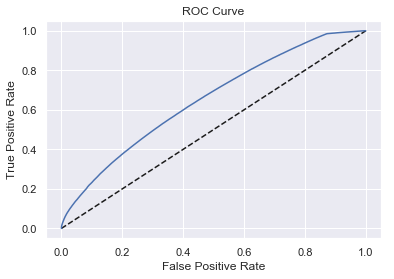

In [15]:
# ROC curve
from sklearn.metrics import roc_curve
y_pred_prob_lr = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lr)

_ = sns.set()
_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.show()

In [16]:
# Calculate area under ROC curve
from sklearn.metrics import roc_auc_score
auc_lr = roc_auc_score(y_test, y_pred_prob_lr)
print(auc_lr)

0.651081743295


### Gradient Boosting Classifier

In [6]:
# Fit model and calculate prediction accuracy
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.01, n_estimators=900, max_depth=9, min_samples_split=600, min_samples_leaf=50, max_features=9, subsample=0.7, random_state=6)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
y_pred_train_gbc = gbc.predict(X_train)
print('Training Set Accuracy: {}'.format(gbc.score(X_train, y_train)))
print('Test Set Accuracy: {}'.format(gbc.score(X_test, y_test)))

Training Set Accuracy: 0.611946343992764
Test Set Accuracy: 0.6084872954244555


In [7]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_gbc))

              precision    recall  f1-score   support

           0       0.61      0.48      0.54    341135
           1       0.61      0.73      0.66    375654

   micro avg       0.61      0.61      0.61    716789
   macro avg       0.61      0.60      0.60    716789
weighted avg       0.61      0.61      0.60    716789



In [8]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_gbc))

[[163024 178111]
 [102521 273133]]


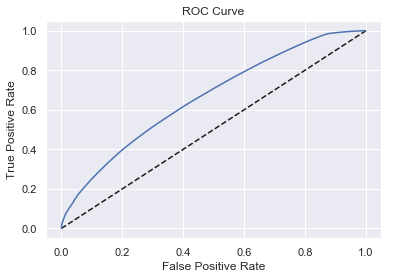

In [9]:
# ROC curve
from sklearn.metrics import roc_curve
y_pred_prob_gbc = gbc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_gbc)

_ = sns.set()
_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.show()

In [10]:
# Calculate area under ROC curve
from sklearn.metrics import roc_auc_score
auc_gbc = roc_auc_score(y_test, y_pred_prob_gbc)
print(auc_gbc)

0.661979996828


### Save Results

Having fully trained my final models and run predictions, I will save the results for future analysis:

In [20]:
# create dataframe of lr coefficients and gbc feature importances
df_features = pd.DataFrame({'coefficient': lr.coef_.flatten(), 'gbc_feature_importance': gbc.feature_importances_}, index=df_model.columns[2:])

# save dataframe to local drive as .csv file
export_df = df_features.to_csv('df_features.csv')

In [ ]:
# create dataframe of training samples
df_train_results = pd.DataFrame(X_train, columns=df_model.columns[2:])

# add fastball labels, lr predictions, and gbc predictions to dataframe
df_train_results['fastball'] = y_train
df_train_results['lr_predict'] = y_pred_train_lr
df_train_results['gbc_predict'] = y_pred_train_gbc

# save dataframe to local drive as .csv file
export_df = df_train_results.to_csv('df_train_results.csv')

In [ ]:
# create dataframe of test samples
df_test_results = pd.DataFrame(X_test, columns=df_model.columns[2:])

# add fastball labels, lr predictions, and gbc predictions to dataframe
df_test_results['fastball'] = y_test
df_test_results['lr_predict'] = y_pred_lr
df_test_results['gbc_predict'] = y_pred_gbc

# save dataframe to local drive as .csv file
export_df = df_test_results.to_csv('df_test_results.csv')

In [ ]:
# create dataframe summarizing results on test set data by pitch type

# divide test set data into subsets based on results for each classifier
df_tp_gbc = df_test_results[(df_test_results['fastball'] == 1) & (df_test_results['gbc_predict'] == 1)]
df_fp_gbc = df_test_results[(df_test_results['fastball'] == 0) & (df_test_results['gbc_predict'] == 1)]
df_tn_gbc = df_test_results[(df_test_results['fastball'] == 0) & (df_test_results['gbc_predict'] == 0)]
df_fn_gbc = df_test_results[(df_test_results['fastball'] == 1) & (df_test_results['gbc_predict'] == 0)]

df_tp_lr = df_test_results[(df_test['fastball'] == 1) & (df_test_results['lr_predict'] == 1)]
df_fp_lr = df_test_results[(df_test['fastball'] == 0) & (df_test_results['lr_predict'] == 1)]
df_tn_lr = df_test_results[(df_test['fastball'] == 0) & (df_test_results['lr_predict'] == 0)]
df_fn_lr = df_test_results[(df_test['fastball'] == 1) & (df_test_results['lr_predict'] == 0)]

# build dataframes for results for types of fastballs and results for types of non-fastballs
df_results_fastballs = pd.DataFrame({'tp_lr': df_tp_lr['pitch_type'].value_counts(), 'fn_lr': df_fn_lr['pitch_type'].value_counts(), 'tp_gbc': df_tp_gbc['pitch_type'].value_counts(), 'fn_gbc': df_fn_gbc['pitch_type'].value_counts()})
df_results_nonfastballs = pd.DataFrame({'fp_lr': df_fp_lr['pitch_type'].value_counts(), 'tn_lr': df_tn_lr['pitch_type'].value_counts(), 'fp_gbc': df_fp_gbc['pitch_type'].value_counts(), 'tn_gbc': df_tn_gbc['pitch_type'].value_counts()})

# add totals and accuracy percentage for each model as columns to dataframes
df_results_fastballs['total'] = df_results_fastballs['tp_lr'] + df_results_fastballs['fn_lr']
df_results_fastballs['accuracy_lr'] = df_results_fastballs['tp_lr'] / df_reults_fastballs['total']
df_results_fastballs['accuracy_gbc'] = df_results_fastballs['tp_gbc'] / df_results_fastballs['total']

df_results_nonfastballs['total'] = df_results_nonfastballs['fp_lr'] + df_results_nonfastballs['tn_lr']
df_results_nonfastballs['accuracy_lr'] = df_results_nonfastballs['tn_lr'] / df_results_nonfastballs['total']
df_results_nonfastballs['accuracy_gbc'] = df_results_nonfastballs['tn_gbc'] / df_results_nonfastballs['total']

# save dataframes to local drive as csv files
export_df_f = df_results_fastballs.to_csv('df_fastball_results.csv')
export_df_nf = df_results_nonfastballs.to_csv('df_nonfastball_results.csv')

In [3]:
# create dataframe summarizing results on test set data by model features

# load the dataframe (if necessary)
df_test_results = pd.read_csv('df_test_results.csv')

# divide test set data into subsets based on results for each classifier
df_tp_gbc = df_test_results[(df_test_results['fastball'] == 1) & (df_test_results['gbc_predict'] == 1)]
df_fp_gbc = df_test_results[(df_test_results['fastball'] == 0) & (df_test_results['gbc_predict'] == 1)]
df_tn_gbc = df_test_results[(df_test_results['fastball'] == 0) & (df_test_results['gbc_predict'] == 0)]
df_fn_gbc = df_test_results[(df_test_results['fastball'] == 1) & (df_test_results['gbc_predict'] == 0)]

df_tp_lr = df_test_results[(df_test_results['fastball'] == 1) & (df_test_results['lr_predict'] == 1)]
df_fp_lr = df_test_results[(df_test_results['fastball'] == 0) & (df_test_results['lr_predict'] == 1)]
df_tn_lr = df_test_results[(df_test_results['fastball'] == 0) & (df_test_results['lr_predict'] == 0)]
df_fn_lr = df_test_results[(df_test_results['fastball'] == 1) & (df_test_results['lr_predict'] == 0)]

# test_results totals
test_results_totals = []
for i in range(len(df_test_results.columns[1:97])):
    test_results_totals.append(df_test_results.iloc[:, i+1].sum())

# tp_lr totals
tp_lr_totals = []
for i in range(len(df_tp_lr.columns[1:97])):
    tp_lr_totals.append(df_tp_lr.iloc[:, i+1].sum())

# fp_lr totals
fp_lr_totals = []
for i in range(len(df_fp_lr.columns[1:97])):
    fp_lr_totals.append(df_fp_lr.iloc[:, i+1].sum())

# tn_lr totals
tn_lr_totals = []
for i in range(len(df_tn_lr.columns[1:97])):
    tn_lr_totals.append(df_tn_lr.iloc[:, i+1].sum())
    
# fn_lr totals
fn_lr_totals = []
for i in range(len(df_fn_lr.columns[1:97])):
    fn_lr_totals.append(df_fn_lr.iloc[:, i+1].sum())
    
# tp_gbc totals
tp_gbc_totals = []
for i in range(len(df_tp_gbc.columns[1:97])):
    tp_gbc_totals.append(df_tp_gbc.iloc[:, i+1].sum())
    
# fp_gbc totals
fp_gbc_totals = []
for i in range(len(df_fp_gbc.columns[1:97])):
    fp_gbc_totals.append(df_fp_gbc.iloc[:, i+1].sum())
    
# tn_gbc totals
tn_gbc_totals = []
for i in range(len(df_tn_gbc.columns[1:97])):
    tn_gbc_totals.append(df_tn_gbc.iloc[:, i+1].sum())
    
# fn_gbc totals
fn_gbc_totals = []
for i in range(len(df_fn_gbc.columns[1:97])):
    fn_gbc_totals.append(df_fn_gbc.iloc[:, i+1].sum())
    
# create dataframe for results by feature
df_features_results = pd.DataFrame({'total': test_results_totals, 'tp_lr': tp_lr_totals, 'fp_lr': fp_lr_totals, 'tn_lr': tn_lr_totals, 'fn_lr': fn_lr_totals, 'tp_gbc': tp_gbc_totals, 'fp_gbc': fp_gbc_totals, 'tn_gbc': tn_gbc_totals, 'fn_gbc': fn_gbc_totals}, index=df_test_results.columns[1:97])

# add accuracy columns for each feature to new dataframe
df_features_results['accuracy_lr'] = (df_features_results['tp_lr'] + df_features_results['tn_lr']) / df_features_results['total']
df_features_results['accuracy_gbc'] = (df_features_results['tp_gbc'] + df_features_results['tn_gbc']) / df_features_results['total']

# save dataframe to local drive as .csv file
export_df = df_features_results.to_csv('df_features_results.csv')

## Summary of Results

Overall, the Gradient Boosting Classifier outperformed the Logistic Regression Classifier.  Here is a table summarizing the results:

In [6]:
df_metrics = pd.read_excel('models_metrics.xlsx')
df_metrics

,metric,lr,gbc
0,Training Set Accuracy,0.602586,0.611946
1,Test Set Accuracy,0.601775,0.608487
2,Non-fastball Precision,0.630000,0.610000
3,Non-fastball Recall,0.400000,0.480000
4,Non_fastball F1-score,0.490000,0.540000
5,Fastball Precision,0.590000,0.610000
6,Fastball Recall,0.780000,0.730000
7,Fastball F1-score,0.670000,0.660000
8,ROC area under curve,0.651080,0.661980


The Gradient Boosting Classifier generated an overall accuracy rate of 0.6085, almost a full percentage point better than the Logistic Regression Classifier's rate of 0.6018. This spread was similarly reflected in the models' respective ROC curve AUC score, as the Gradient Boosting Classifier generated a score of 0.6620 compared to the Logisitic Regression Classifier's 0.6510.  Therefore, the Gradient Boosting Classifier should be preferred if overall accuracy is a team's priority.

The decision may not be so straightforward, however, if a team prioritizes identifying one type of pitch over another.  Let's examine the results for each pitch type to provide a clearer picture on model performance.

### Non-Fastballs


In [14]:
df_nf = pd.read_csv('df_nonfastball_results.csv', index_col=0)
df_nf.sort_values('total', ascending=False)

,fp_lr,tn_lr,fp_gbc,tn_gbc,total,accuracy_lr,accuracy_gbc
SL,69463,42957,60222,52198,112420,0.382112,0.464312
CH,47294,25976,41410,31860,73270,0.354524,0.434830
SI,27304,33261,24234,36331,60565,0.549179,0.599868
CU,39374,19411,34327,24458,58785,0.330203,0.416059
KC,10991,5760,9702,7049,16751,0.343860,0.420811
FS,6572,4330,5771,5131,10902,0.397175,0.470648
MISSING,1033,2465,1192,2306,3498,0.704688,0.659234
KN,960,1809,857,1912,2769,0.653304,0.690502
IN,245,1339,104,1480,1584,0.845328,0.934343
EP,91,139,79,151,230,0.604348,0.656522


As we can see from the above table, the Gradient Boosting Classifier identified each type of non-fastball at a higher accuracy rate than the Logistic Regression Classifier (with the exception of the pitches that were missing a pitch type classification).  The Gradient Boosting Classifier accordingly should be used by any team that prioritizes identifying when the next pitch will be a non-fastball.

It is worth noting that neither classifier does particularly well in identifying non-fastballs.  The Gradient Boosting Classifier correctly classified 47% of non-fastballs, which significantly outperformed the Logistic Regression Classifier's recall rate of 40%.  However, the Logistic Regression Classifier generated a slightly higher precision rate (0.63 v. 0.62).  

Both models therefore clearly suffer from overclassifying pitches as fastballs.  Let's examine the fastball data:

### Fastballs

In [18]:
df_f = pd.read_csv('df_fastball_results.csv', index_col=0)
df_f.sort_values('total', ascending=False)

,tp_lr,fn_lr,tp_gbc,fn_gbc,total,accuracy_lr,accuracy_gbc
FF,195776,57976,182164,71588,253752,0.771525,0.717882
FT,68812,15676,63826,20662,84488,0.814459,0.755445
FC,29192,8222,27143,10271,37414,0.780243,0.725477


As demonstrated above, the Logistic Regression Classifier was more accurate in identifying each of the three types of fastballs by a significant margin.  The Logistic Regression Classifier correctly classified 78% of fastballs, which significantly outperformed the Gradient Boosting Classifier's recall rate of 73%.

However, the Logistic Regression Classifier generated only a marginally higher F1-score with respect to fastballs than the Gradient Boosting Classifier (0.67 v. 0.66), and the Gradient Boosting Classifier produced a slightly higher precision rate (0.60 v. 0.59).  This can be accounted for by the fact that the Logistic Regression Classifier predicts fastballs at a much higher overall rate than the Gradient Boosting Classifier - the Logistic Regression Classifier predicted approximately 70% of the pitches to be fastballs, significantly higher than the Gradient Boosting Classifier's rate of approximately 63% of the pitches.  The Logistic Regression Classifier therefore produces more Type I errors/False Positive predictions than the Gradient Boosting Classifier (203,569 v. 178,111), but less Type II errors/False Positive predictions (81,874 v. 102,521). 

All that being said, a team should consider using the Logistic Regression Classifier if its top priority is to maximize the number of fastballs identified correctly.


### Feature Performance

Next, I will evaluate the accuracy performance of the models based on each model feature.  The first chart below demonstrates the 15 features that produced the highest accuracy (for the GBC model).  The second chart below demonstrates the 15 features that producted the lowest accuracy (for the GBC model).

In [7]:
df_features_results[['accuracy_lr', 'accuracy_gbc']].sort_values('accuracy_gbc', ascending=False)[:15]

,accuracy_lr,accuracy_gbc
prev_pitch_IN,1.000000,1.000000
"px_prev_(3.467, 4.0]",0.949886,0.940774
"px_prev_(-4.008, -3.467]",0.939609,0.939609
prev_pitch_KN,0.899221,0.897274
prev_pitch_SI,0.879638,0.879638
b_count_3,0.723751,0.726064
"px_prev_(-3.467, -2.933]",0.732601,0.710623
prev_pitch_EP,0.674603,0.706349
"px_prev_(2.933, 3.467]",0.743590,0.705128
prev_pitch_SC,0.958333,0.666667


In [8]:
df_features_results[['accuracy_lr', 'accuracy_gbc']].sort_values('accuracy_gbc', ascending=True)[:15]

,accuracy_lr,accuracy_gbc
prev_pitch_CU,0.543829,0.550644
prev_pitch_CH,0.547242,0.552487
prev_pitch_KC,0.550387,0.557814
prev_pitch_FO,0.570470,0.563758
prev_pitch_FS,0.560411,0.565743
prev_pitch_SL,0.564841,0.569172
inning_4,0.570790,0.577222
"pz_prev_(-1.006, -0.6]",0.587368,0.579474
prev_pitch_PO,0.607843,0.581699
"pz_prev_(-0.6, -0.2]",0.581717,0.586911


As the above tables demonstrate, with very few exceptions the two models produced roughly the same accuracy for each of the model features.  On average, the Gradient Boosting Classifier tends to perform slightly better on most features, accounting for its superior overall accuracy discussed above.

The features that the models produce the highest accuracy mostly comprise of certain previous pitch type and location data.  Interestingly, however, certain other previous pitch types and location data produced the least accurate results.  The models also produced low accuracy numbers on pitches in the middle innings.

Overall, this demonstrates that the previous pitch features that I added to the model produced the most skewed results (which I knew implicitly given how the models’ overall performance numbers improved significantly once these features were added).  Future work on these models should include focusing on these features to see if any more specific patterns/insights can be identified.

I also would like to take a deeper dive into the pitches that occur in the middle innings. While I am skeptical that it is the middle inning features themselves that are causing the poor accuracy results, it could be indicative of other patterns/trends in the data that occur more often in the middle innings, which thereby cause the models to mislabel more pitches.


### Logistic Regression Coefficients

In [11]:
df_features = pd.read_csv('df_features.csv', index_col=0)
df_features.sort_values('coefficient', ascending=False)[:15]

,coefficient,gbc_feature_importance
prev_pitch_FC,3.038671,0.037677
prev_pitch_FT,2.808360,0.043790
prev_pitch_FF,2.742564,0.080825
prev_pitch_FO,2.498353,0.000017
prev_pitch_PO,2.437529,0.000003
prev_pitch_CU,2.388296,0.002738
prev_pitch_CH,2.296203,0.004120
prev_pitch_KC,2.292289,0.001203
prev_pitch_SL,2.232262,0.014552
prev_pitch_FS,2.182986,0.001184


The above dataframe contains the coefficient values assigned to each feature by the fully-trained Logistic Regression Classifier (as well as the feature importances assigned by the Gradient Boosting Classifier, which we will analyze next).  The dataframe has been sorted to display the 15 features with the largest positive coefficient values.  As you can see, the classifier prioritizes the previous pitch type as most important, with 12 of the 15 being different previous pitch types. Interesting, the top 3 values (FC, FT, FF) are the three types of fastballs that comprise our `fastball` label.  This is an area that will require future investigation - if certain of these pitch types don’t correlate with the next pitch being a fastball, it may make sense to remove these features from the model to see if it would improve the model’s accuracy.

It also determined that a batting count with 3 balls is relatively significant to the next pitch being a fastball, which is consistent with what we observed during our exploratory data analysis.  Finally, it found slight significance in the previous pitch having a negative vertical location (i.e., hitting the dirt below the plate).  Those likely are quite a small sample size and therefore probably not signficantly impacting the model's performance.

In [4]:
df_features = pd.read_csv('df_features.csv', index_col=0)
df_features.sort_values('coefficient')[:15]

,coefficient,gbc_feature_importance
prev_pitch_IN,-6.606109,0.012344
pitch_num_2,-2.442173,0.015921
pitch_num_9,-2.365207,0.000290
pitch_num_10,-2.348446,0.000115
pitch_num_8,-2.307592,0.000622
pitch_num_7,-2.278462,0.001283
pitch_num_6,-2.260869,0.003287
pitch_num_3,-2.185861,0.012325
pitch_num_5,-2.124169,0.010369
pitch_num_4,-2.080146,0.010544


Conversely, the Logistic Regression Classifier assigns large negative value coefficients to features it has learned correlate to non-fastballs.  The outlier feature is for the previous pitch being an intentional ball.  This makes logical sense because intentional balls are thrown when a pitcher intentionally walks a batter, in which case the pitcher throws four consecutive intentional balls.  The other previous pitch type listed is a screwball, which is also an outlier given how few pitchers throw screwballs.

The most significant trend that the classifier learned is that pitch numbers 2-10 of a batting count are indicative of non-fastballs.  This is consistent with what we discovered during exploratory data analysis, though we observed that the frequency of fastballs increased to above average from pitches 6-10.

The classifier also assigned significance to batting counts with one or two strikes.  This is largely consistent with what we observed during exploratory data analysis.

## Gradient Boosting Feature Importances

In [5]:
df_features = pd.read_csv('df_features.csv', index_col=0)
df_features.sort_values('gbc_feature_importance', ascending=False)[:15]

,coefficient,gbc_feature_importance
prev_pitch_SI,0.231926,0.379442
prev_pitch_FF,2.742564,0.080825
b_count_3,0.724995,0.057462
s_count_2,-0.937326,0.054237
prev_pitch_FT,2.808360,0.043790
prev_pitch_FC,3.038671,0.037677
inning_pitch_count,-0.094548,0.029650
s_count_1,-0.600940,0.021992
b_count_1,-0.199580,0.020831
prev_pitch_KN,0.085609,0.019515


The feature importance values in the Gradient Boosting Classifier is an indication of how important each feature was in assisting the classifier in making the classification decision.  Unlike the Logistic Regression Classifier's coefficients, we are unable to know whether the feature is important in identifying fastballs or non-fastballs.  All that the number communicates is the relative overall importance of the feature.

Here, we can see that the Gradient Boosting Classifier has determined the previous pitch slider feature as the most important feature by a significant margin.  It also has assigned relative importance to the three types of fastballs that make up our `fastball` label, which is consistent with what the Logistic Regression Classifier observed (indicative that the next pitch will also be a fastball).  In future work, I intend to investigate pitches following sliders to determine if the classifier is correct in assigning such a high level of importance to that feature.

The model has also assigned relatively high importance to batting counts with 3 balls or 2 strikes.  This is consistent with what we observed during exploratory data analysis (3-ball counts are indicative of fastballs, 2-strike counts of non-fastballs).  It is less clear why it assigned relative importance to 1-ball, 1-strike, and 2-ball counts.  It may be worth experimenting in removing these features to see if that would improve the model's overall performance.

The model also observed importance in the number of pitches thrown by the pitcher in the inning (it could be that more fastballs are thrown later in the inning to avoid walks) and runners on second base (indicative of non-fastballs).  It also applied some importance to the second pitch of an at-bat, which we observed during exploratory data analysis to be more likely to be a non-fastball.

In [8]:
df_features = pd.read_csv('df_features.csv', index_col=0)
df_features.sort_values('gbc_feature_importance')[:15]

,coefficient,gbc_feature_importance
prev_pitch_SC,-1.036591,0.000000
prev_pitch_PO,2.437529,0.000003
prev_pitch_FO,2.498353,0.000017
"px_prev_(-3.467, -2.933]",0.035960,0.000018
prev_pitch_EP,1.916104,0.000086
pitch_num_10,-2.348446,0.000115
"px_prev_(2.933, 3.467]",-0.236866,0.000131
pitcher_lead_-9,-0.005301,0.000145
"px_prev_(-2.933, -2.4]",-0.000748,0.000150
pitcher_lead_-8,-0.033039,0.000271


In analyzing the features that the Gradient Boosting Classifier assigned the least amount of importance, it becomes clear that most if not all of the features tend to be outlier values.  Among the features are previous pitch types that are rarely thrown (screwballs, pitchouts, eephus), game scores in which the pitcher's team is winning (or losing) by a wide margin, extreme previous pitch location values, and the last pitches of abnormally long at-bats (9 or greater).  It may make sense to consider dropping these outlier features in future iterations of this model, though I would not expect that to significantly impact the model's overall performance given the relative infrequency of these features in the dataset and the low importance the model assigns to them.

## Conclusions

This project demonstrates that it is possible to analyze pre-pitch circumstances to predict whether a pitcher is going to throw a fastball as the next pitch at a higher accuracy rate than the default frequency percentage of 52.41%.  It is important to note that the models struggled to outperform the default rate without information regarding the previous pitch despite observing correlations between fastball frequency and certain of these circumstances (runners on base, batting count, pitch sequence, game score, etc.).  It is interesting to note that, while correlations between certain game circumstances and fastball frequency do exist, the same overall game circumstances did not significantly improve the algorithms' ability to predict fastballs when considering all of that data in the aggregate.

Once we included information about the pitcher's inning pitch count, the immediate previous pitch type thrown, and the location of the immediate previous pitch, the models' respective accuracy improved significantly by approximately 5-8%.  Teams therefore should be able to use one of the final models to correctly identify when a pitcher will throw a fastball or non-fastball more often than competitors not using such a model.

The Gradient Boosting Classifier should be used for most circumstances given its overall superior performance.  As explained in detail above, the Gradient Boosting Classifier performed substantially better in identifying non-fastballs and generated higher accuracy numbers on most of the model features.  It also appears to have more potential to improve through future work.

That being said, a user should consider using the Logistic Regresion Classifier under circumstances in which the user is concerned only (or primarily) with identifying when a fastball will be thrown and is less concerned about mis-identifying non-fastballs as fastballs.

## Future Work for Potential Model Improvements

I believe that I potentially could improve the performance of the final models generated by this project with some additional work.  The main hurdles that I encountered with this project were the large size the data (over 2.8 million pitches) and the limited computational power and time available.  With more time and access to more computational power, I think the models could potentially be improved through exploration of one or more of the following:


-  **Adding more previous pitch data as additional features.**  I was only able to add certain previous pitch features to the dataset given how much time/computational power it took to build them.  If I had more time and computational power, I would suggest adding the other previous pitch data available for the immediate previous pitch (pitch speed, break length, spin rate, etc.).  I also would suggest adding the same information for each previous pitch for an entire at-bat (rather than only the data from the immediate previous pitch).  I believe this has the potential to improve the model performance given how significantly the previous pitch features improved my model in this project;


-  **Adding interaction terms using `PolynomialFeatures`.**  My exploratory data analysis demonstrated some correlations between certain pre-pitch game circumstances and a pitcher's fastball usage (e.g., runners in scoring position, whether the pitcher is ahead or behind in the count, whether the pitcher's team is winning or losing, etc.).  However, the models were unable to capture much (if any) significance of these circumstances when making fastball predictions in the aggregate.  Adding interaction terms would potentially allow the models to more accurately identify the significance of two (or more) of these circumstances being present at the same time.  I was unable to incorporate this step given my time and computing power limitations, but in future work I would like to explore whether interaction terms would improve the models;


-  **Removing certain existing features.**  As explained above, I would like to do some further feature-specific analysis/testing to determine whether the models may perform better without inclusion of certain features.  In particular, the models appeared to be quite sensitive to the previous pitch features that I added.  By comparing the feature coefficient/importance values against one another and to the observations made during my exploratory data analysis, I think I may be able to identify some features that are not improving model performance.  Removing some features would reduce the size of the dataset and make it more manageable to analyze; and


-  **Tuning the hyperparameters with a larger portion of the data.**  I only used approximately 5% of the data to tune my model hyperparameters given my time and computational power constraints. Tuning the models on the smaller data sample did not meaningfully improve their performance. Tuning the models on a greater percentage of the data potentially could produce different optimal hyperparameter values for the models, though not likely unless the 5% sample of my data happened to be a poor representative of the entire dataset.  I would like to perform this exercise to confirm that I identified the optimal hyperparameters for my models.
